# Analysis of NeuroPracticum Electrophysiological Data

In this notebook, we develop an analysis pipeline for the electrophysiological data collected at NeuroPracticum using the QPatch Compact machine.

## Normal imports
We import numpy, pandas, os, scipy, matplotlib.pyplot, and seaborn for this notebook.

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = None
import math
import os
import scipy
from itertools import compress
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.optimize import curve_fit
import scipy.optimize as optimize
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import seaborn as sns
sns.set()
import statsmodels.stats.api as sms
!pip install xlrd


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Importing data
NeuroPracticum data currently exists in the form of Excel files, each named with the date and "cell ID", and nested in folders depending on the date. Each excel file has a single sheet with a time array in the first column. Each subsequent pair of columns are the voltage (first column of the pair) and current (second column of the pair) for a single sweep. 

Here's a function to import all the excel files in multiple nested folders into a single dictionary. 

In [5]:
def folder_to_list(folder_path):
    #move into specified folder
    os.chdir(folder_path)
    #make a list of all the excel files in the folder
    folders = [x for x in os.listdir() if x != '.DS_Store']
    big_dictionary = {}
    for x in folders:
        date = x
        new_folder = str(folder_path+'/'+x)
        os.chdir(new_folder)
        files = [y for y in os.listdir() if os.path.splitext(y)[1] == '.xls']
        all_files = {}
        for file in files:
            all_files[f'{file}'] = pd.read_excel(file, sheet_name = 'Sheet0')
        big_dictionary[f'{date}'] = all_files
    return big_dictionary

Here's a series of functions that reformat the initial dictionary with all excel files (and unformatted data) into a dictionary where files are separated by date, file name, cell ID, and data (time array, current and voltage arrays for each sweep in the form of a DataFrame.)

In [6]:
def processing(all_dfs):
        #compile all data in a dictionary (from the folder extract)
        cleaned = {}
        ind = 0
        ids = []
        for x, df in all_dfs.items():
            #collect data and construct based on dictionary name (corresponds with a single excel file)
            date = x
            for y, file in df.items():
                file_name = y
                data = pre_process_sheet(file)
                cell_id = file_name[file_name.find('id ')+3:file_name.find('id ')+6]
                cleaned[ind] = {'date': date, 'file': file_name, 'id': cell_id, 'data': data}
                ids.append(cell_id)
                ind +=1
        ids = np.unique(ids)
        #print the total number of cells processed (regardless of inclusion/exclusion) and return a dictionary of only included cells
        return cleaned, ids

def consolidating(some, ids):
    final = {}
    index = 0
    for z in ids:
        counter = 0
        compiled_data = {}
        for m, info in some.items():
            if info['id'] == z:
                indexing_data = 'data' + str(counter)
                counter += 1
                metadata = {'date': info['date'], 'file_name' : info['file']}
                compiled_data[indexing_data] = {'metadata': metadata, 'data' : info['data'], 'index' : index}
                index += 1
        final[z] = compiled_data
    return final
    
def pre_process_sheet(sheet):        
    sampling_rate = np.mean(np.diff(np.array(sheet.iloc[:10,0])*1000))
    times = pd.DataFrame({'Time [ms]': np.array(sheet.iloc[:,0])*1000})
        #get background array (1st ROI)
    sweep = {}
    col_names = []
        #for loop to cycle through each subsequent ROI in a sheet, will add to the \\cells\\ dictionary
    for y in range(1, int((len(sheet.columns)-1)/2)):
        voltage = np.array(sheet.iloc[:,((y*2)-1)])
        current = np.array(sheet.iloc[:,((y*2))])
        title_current = 'sweep '+ str(y) + ': current [pA]'
        title_voltage = 'sweep '+ str(y) + ': voltage [mV]'
                #appends the \\processed\\ values into the \\cells\\ dictionary
        sweep[f'{title_current}'] = current * (10**9)
        sweep[f'{title_voltage}'] = voltage * 1000
        col_names.append(title_current)
        col_names.append(title_voltage)
            #converts \\cells\\ dictionary to dataframe for easier manipulation    
    sweeps = pd.DataFrame(sweep, columns = col_names)
    final = pd.concat([times, sweeps], axis = 1)
    return final


Here we use those functions to import all our excel files.

In [7]:
today = folder_to_list('/Users/alicelin/Documents/GitHub/neur2060-spring23-final_project/neuropracticum/')
#change folder path as needed
some, ids = processing(today)
final = consolidating(some, ids)

Now we visualize the data in each excel file (in plot form) to determine what types of analysis are needed.

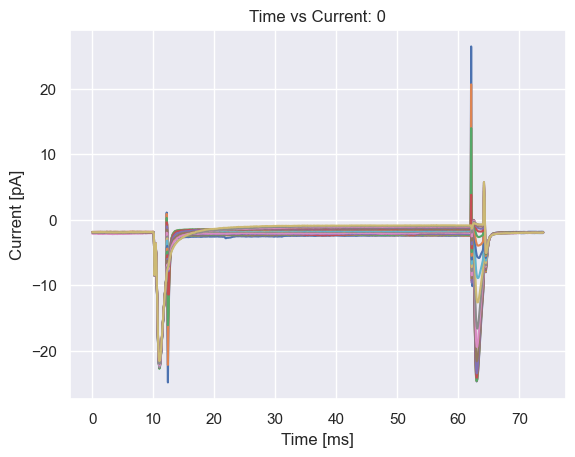

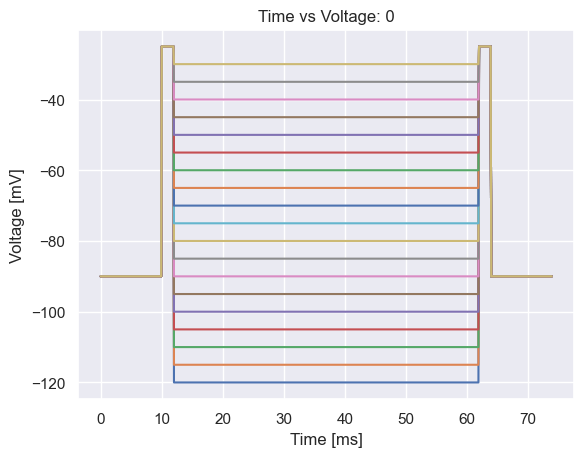

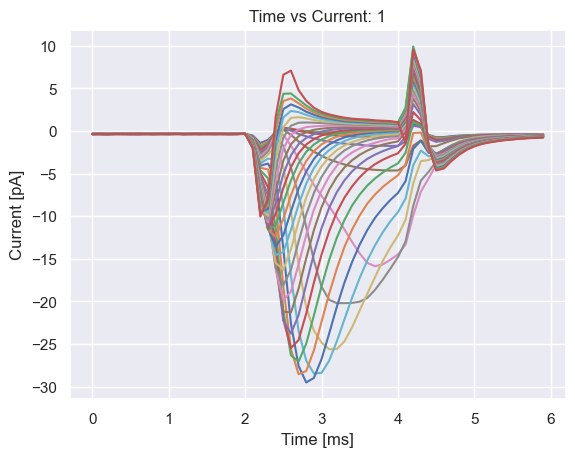

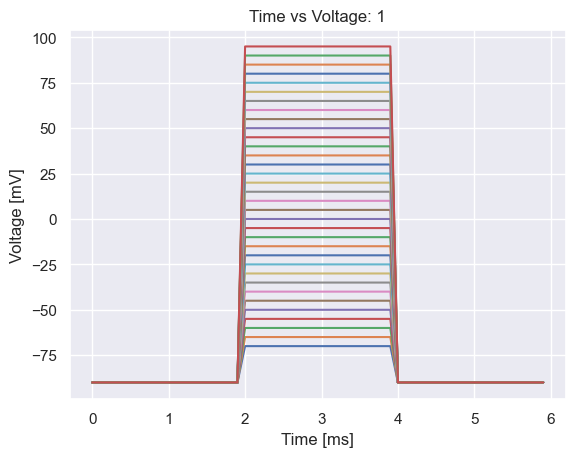

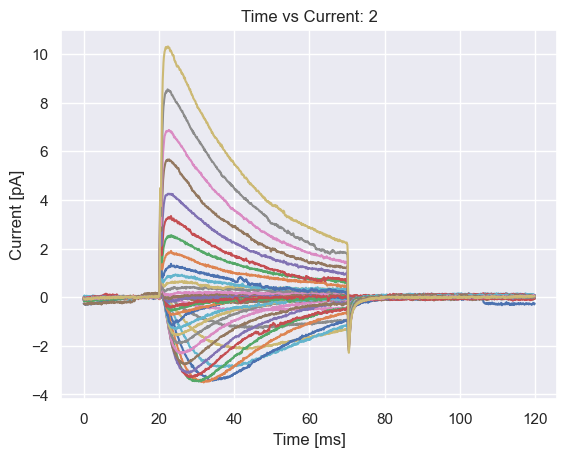

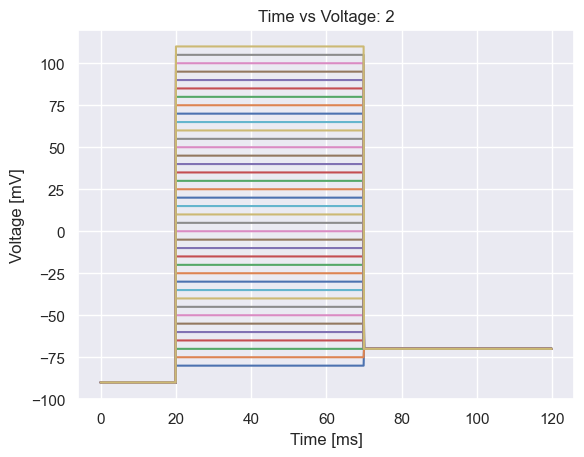

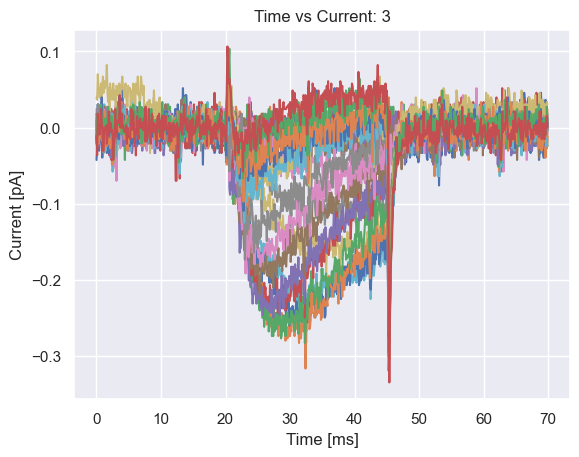

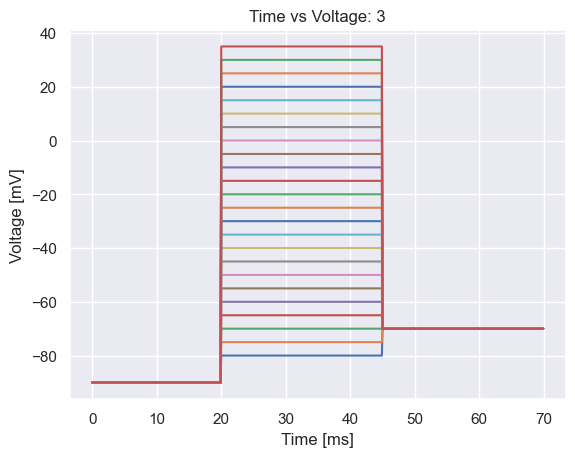

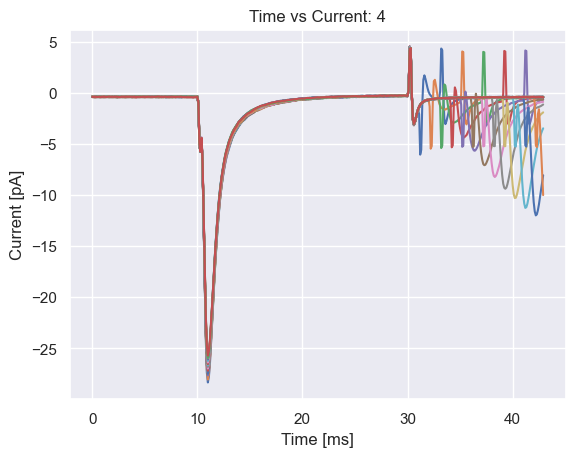

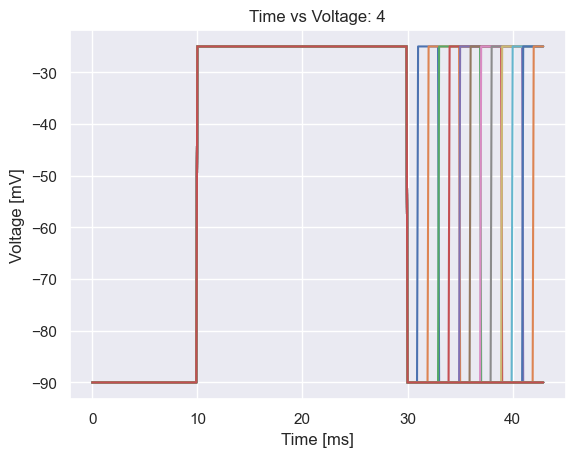

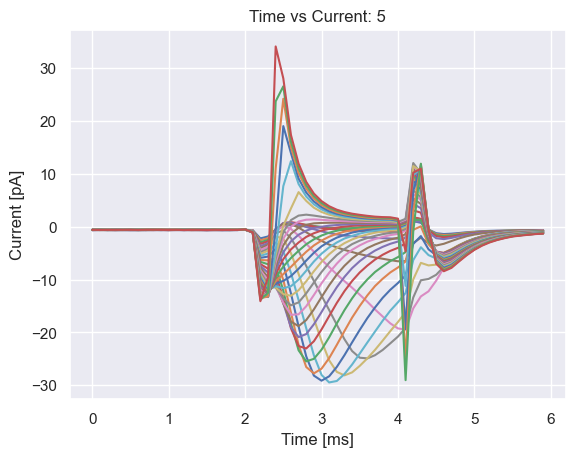

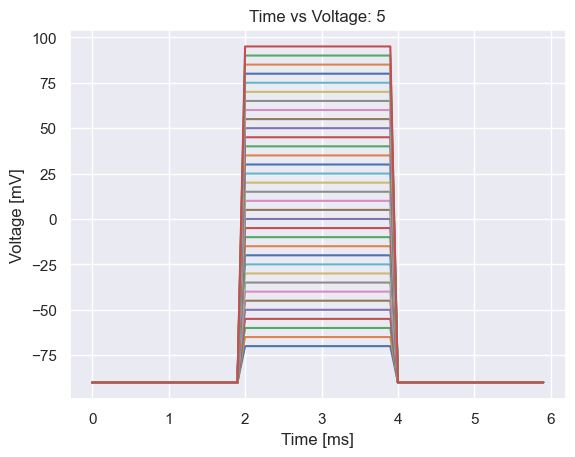

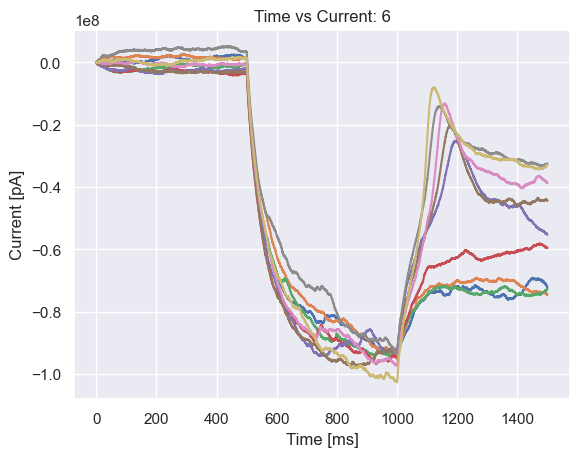

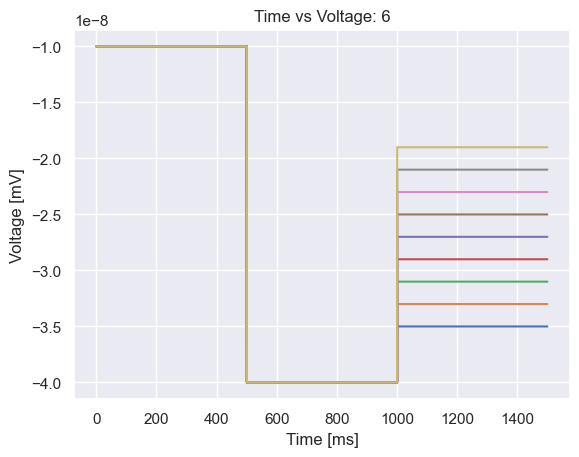

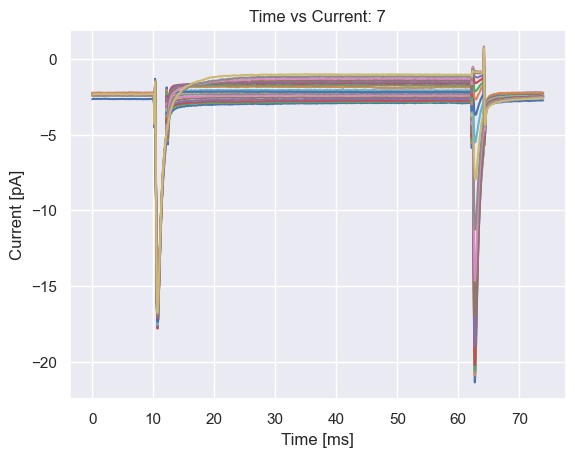

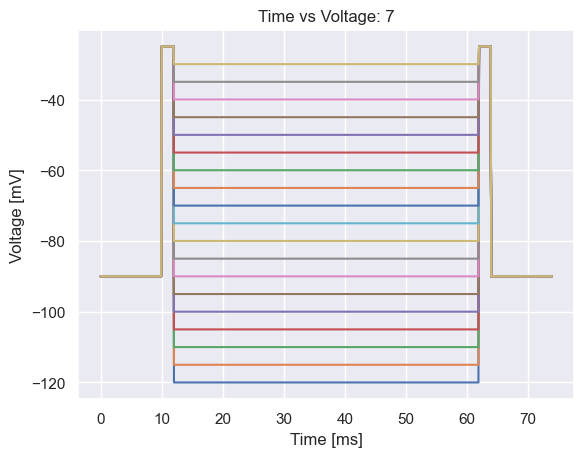

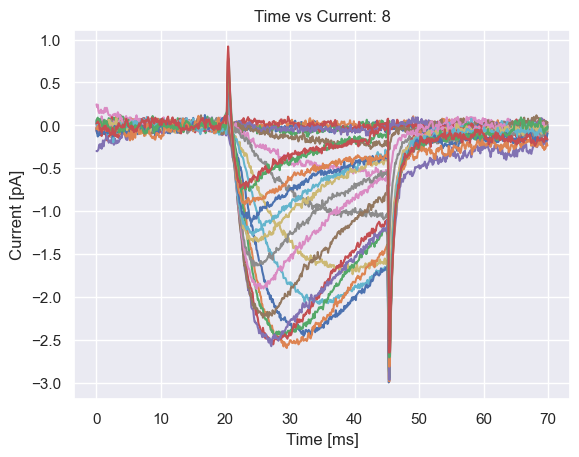

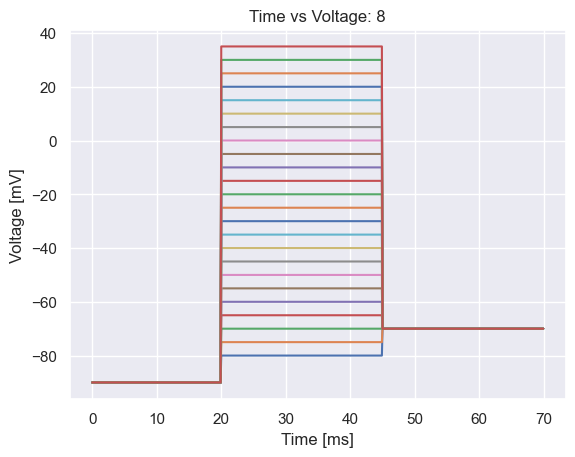

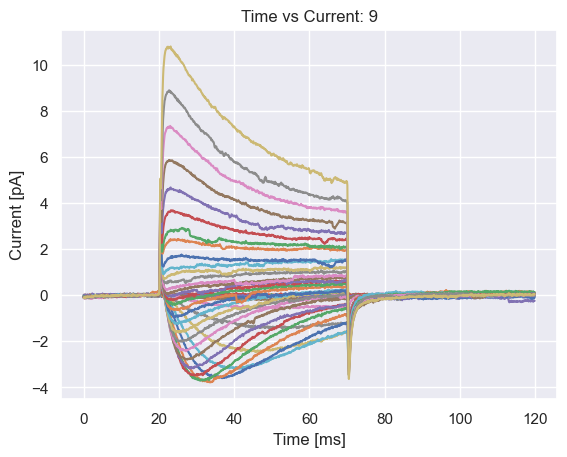

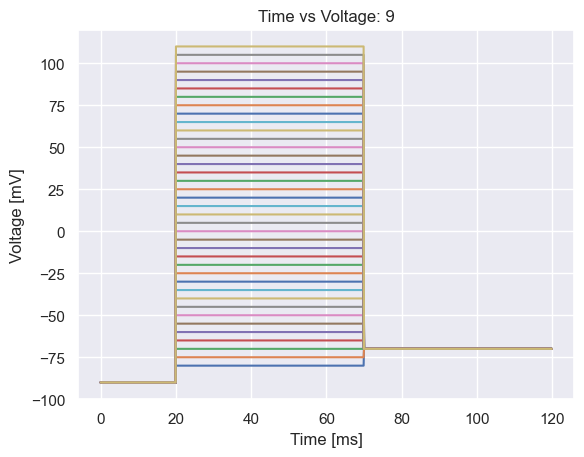

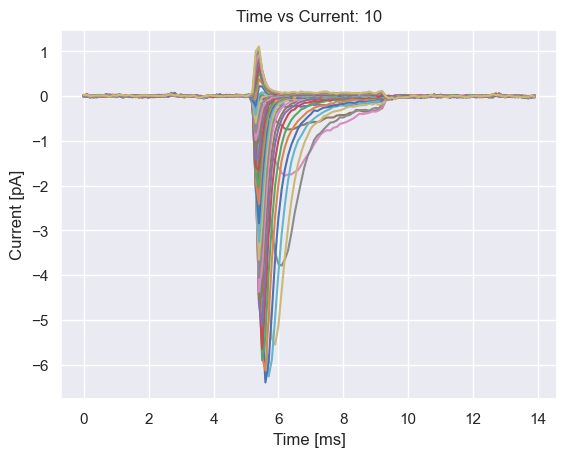

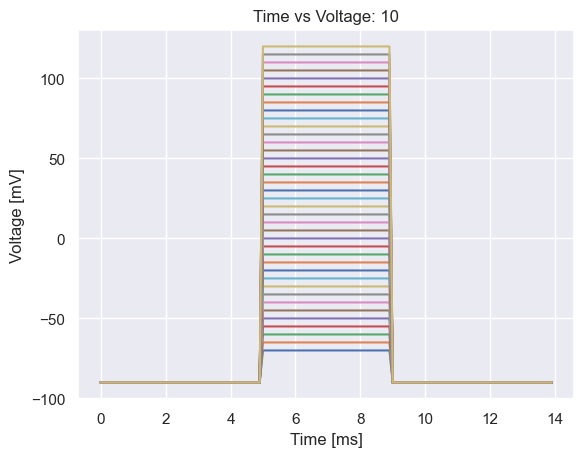

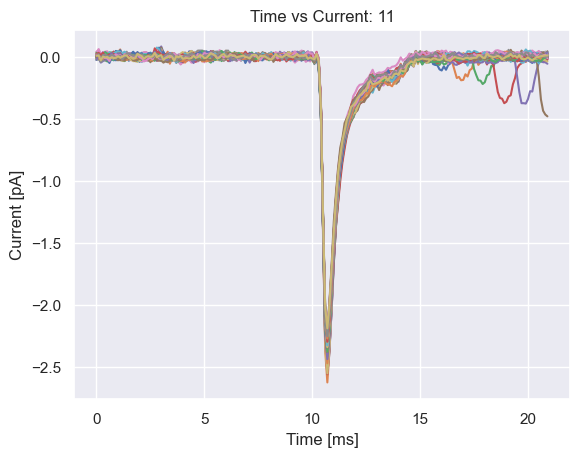

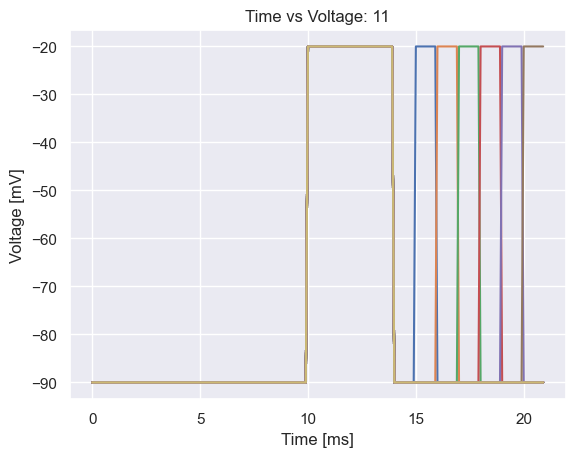

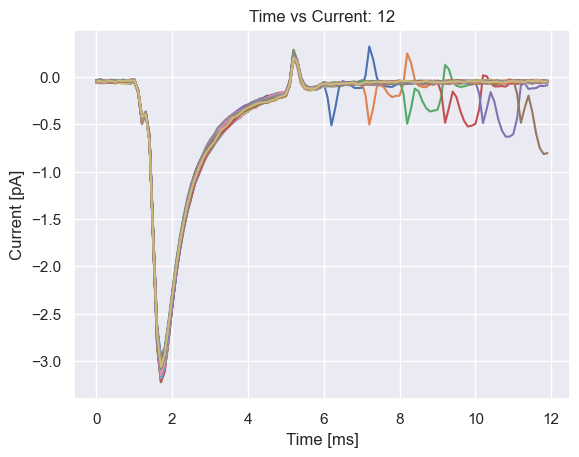

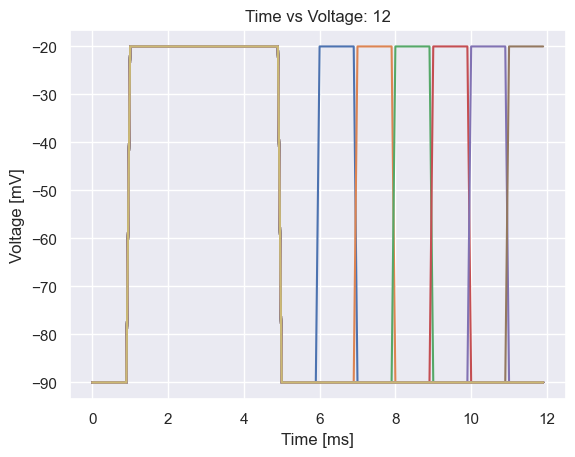

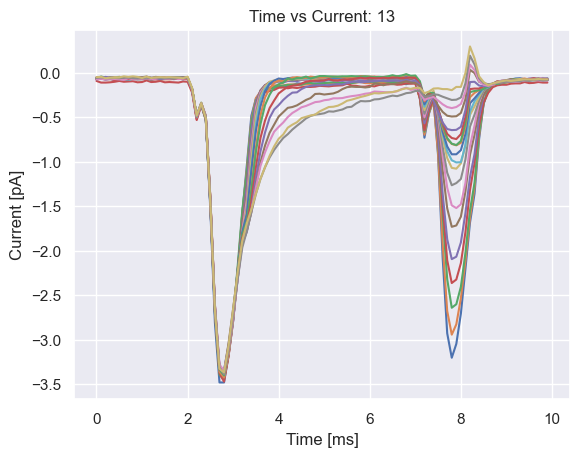

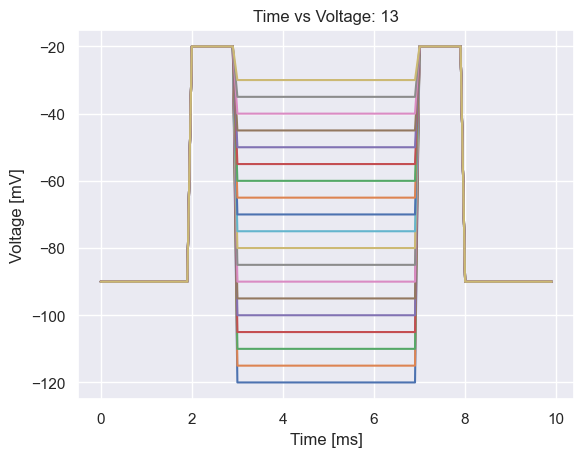

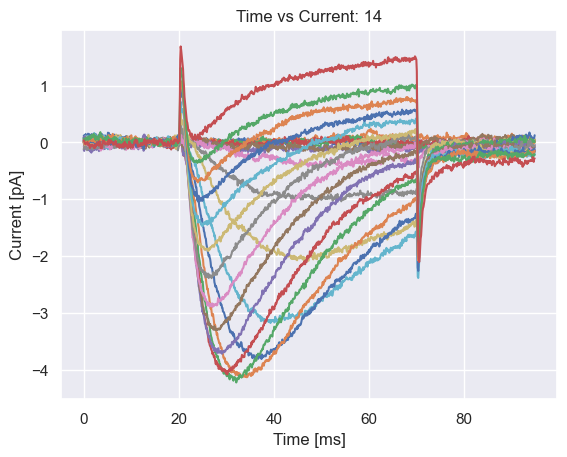

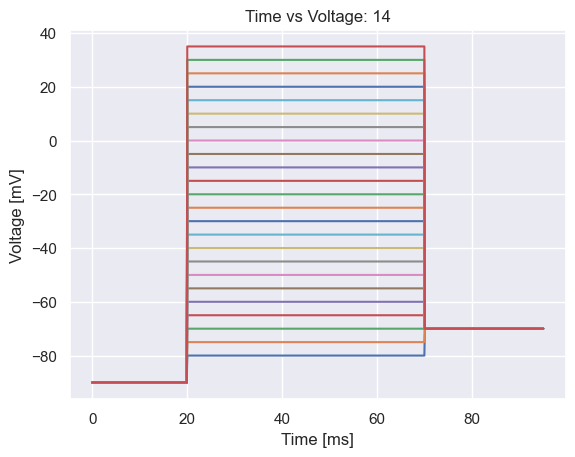

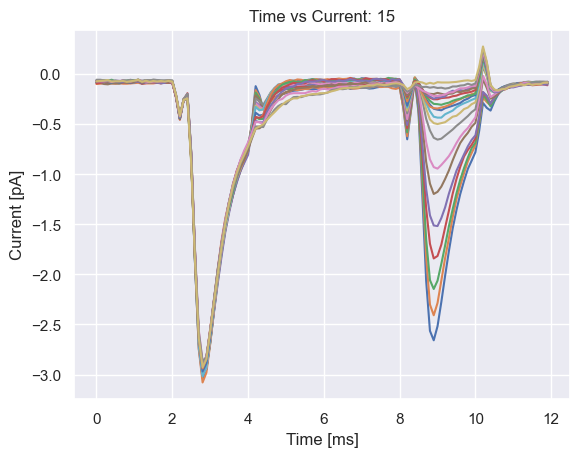

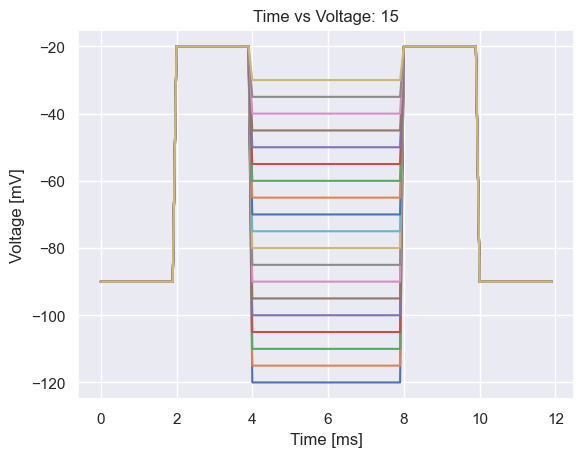

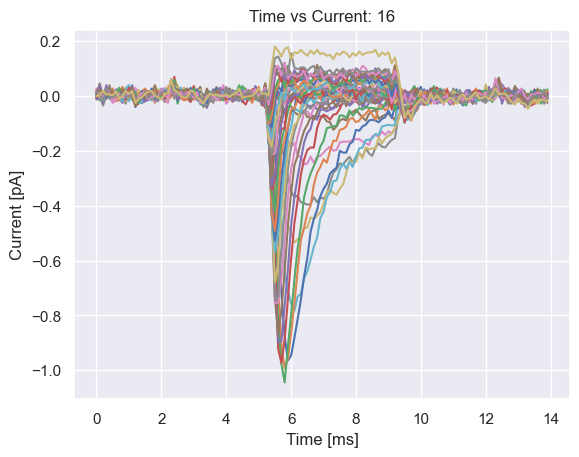

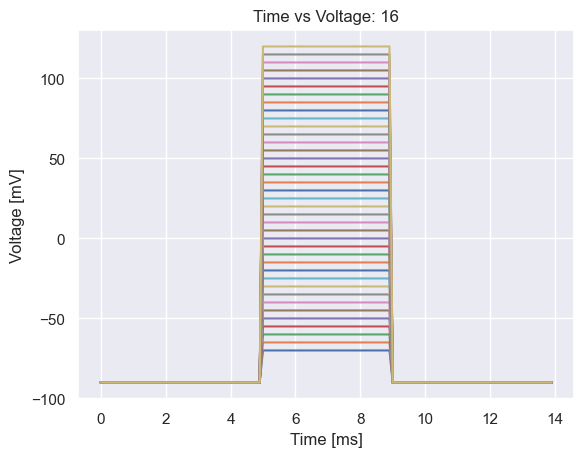

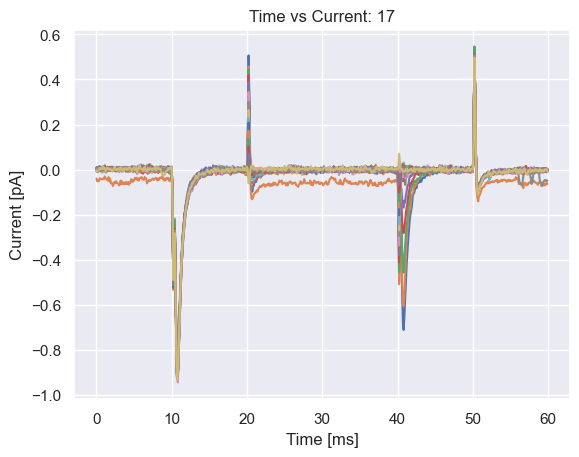

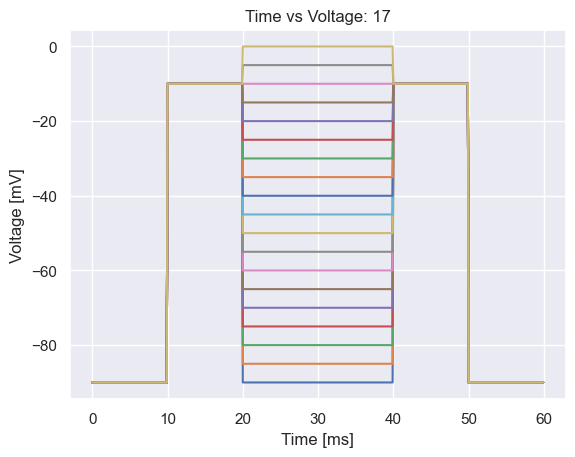

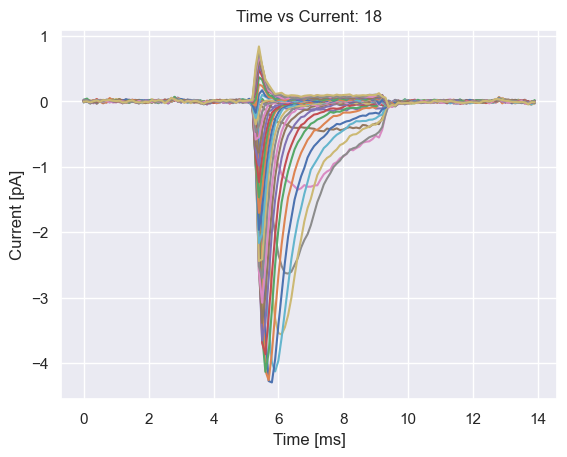

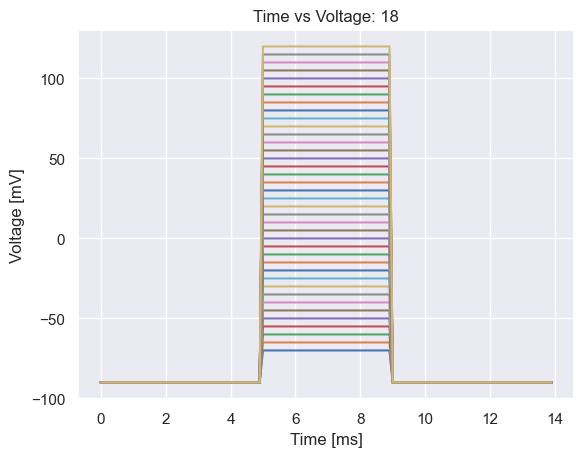

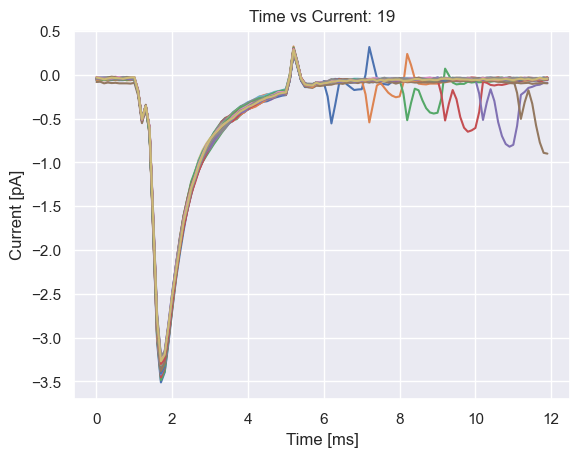

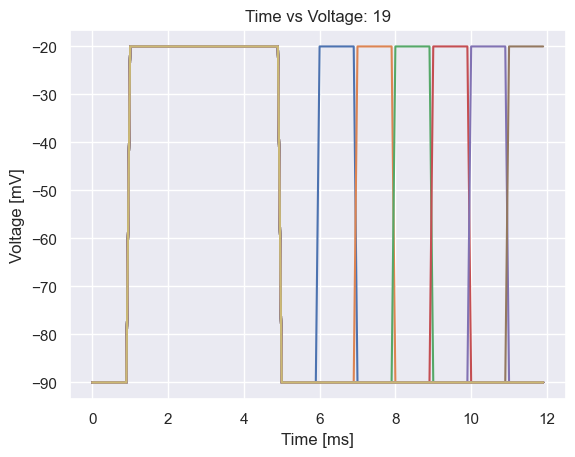

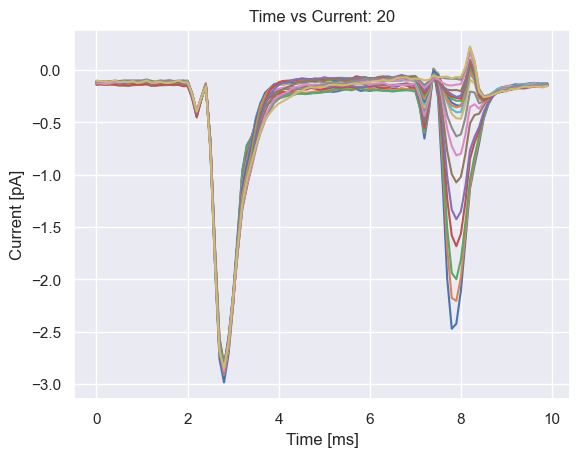

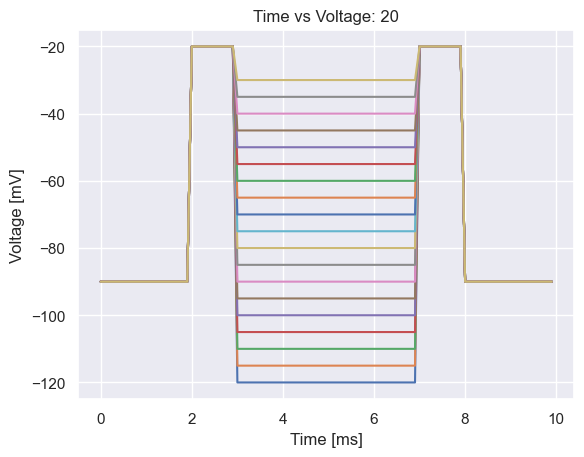

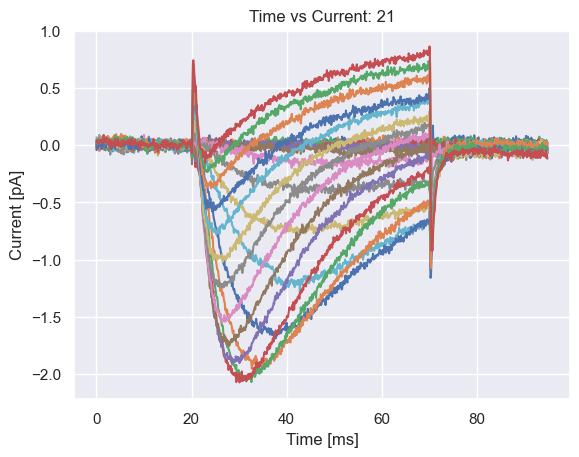

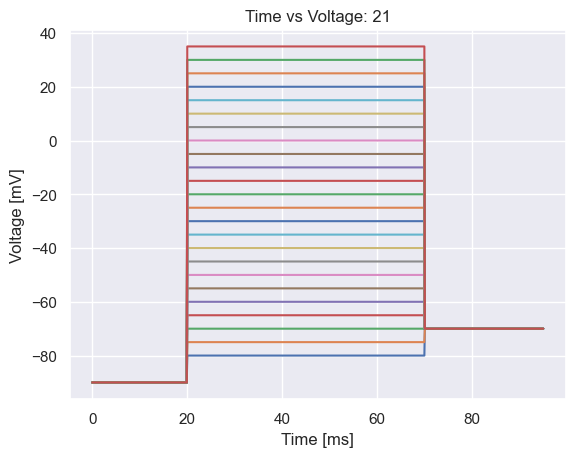

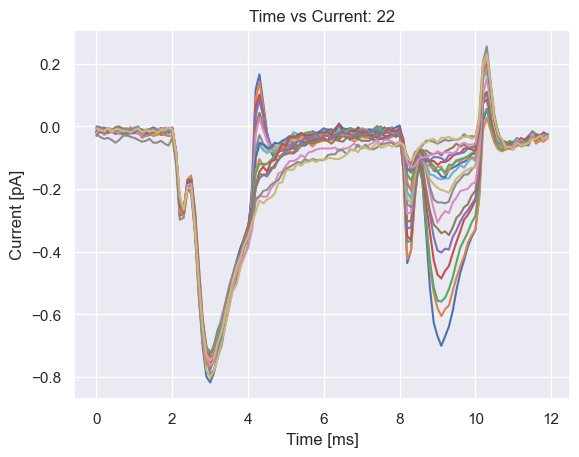

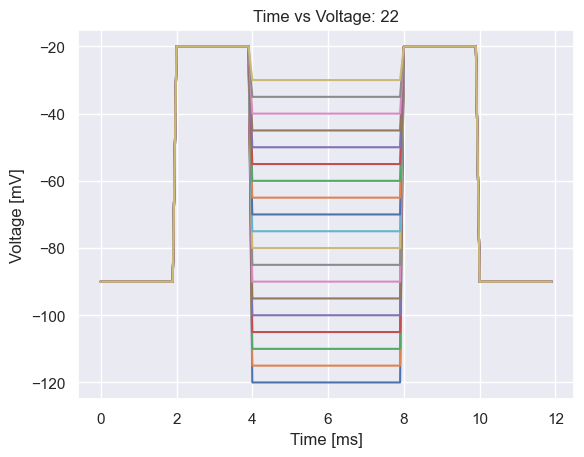

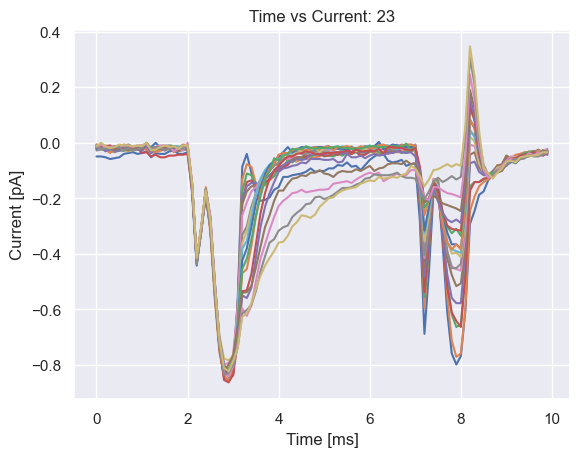

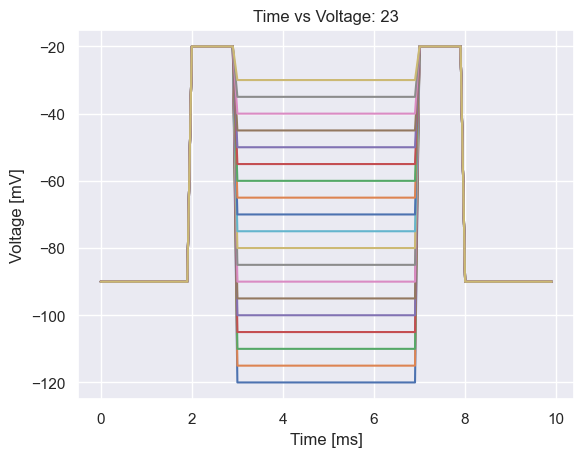

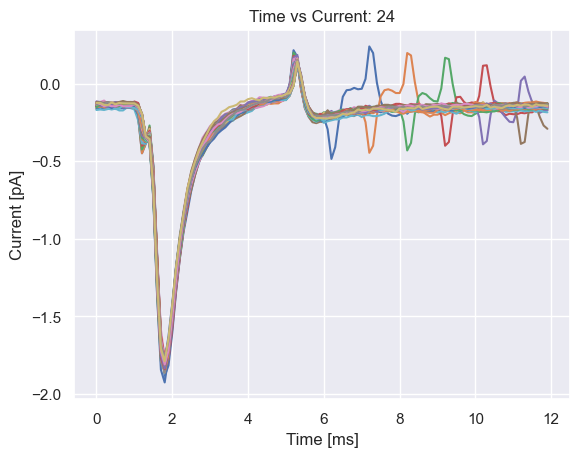

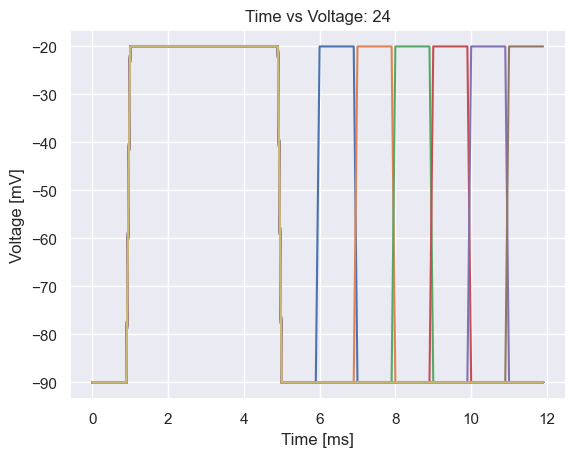

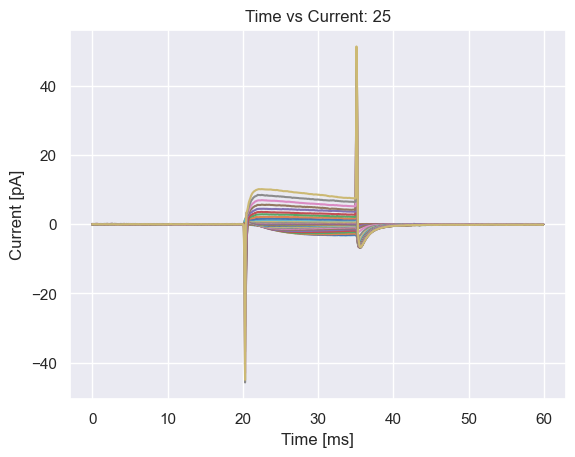

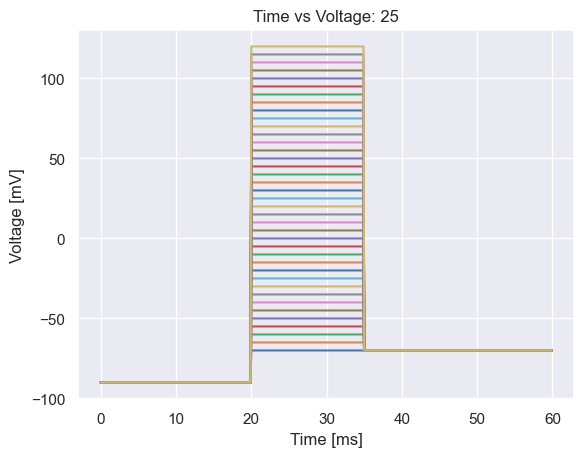

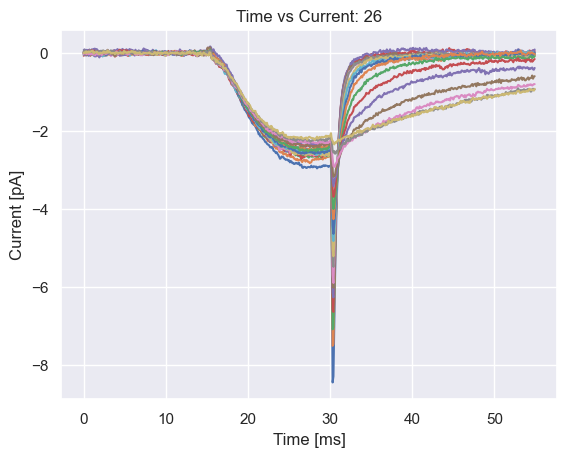

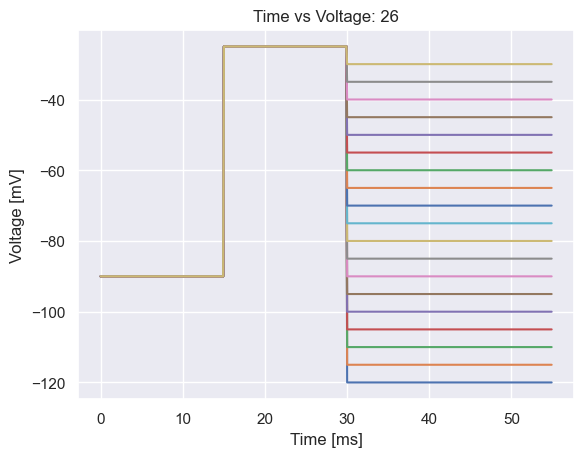

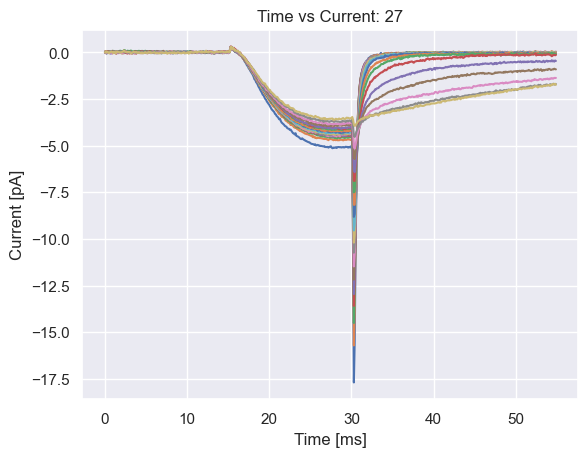

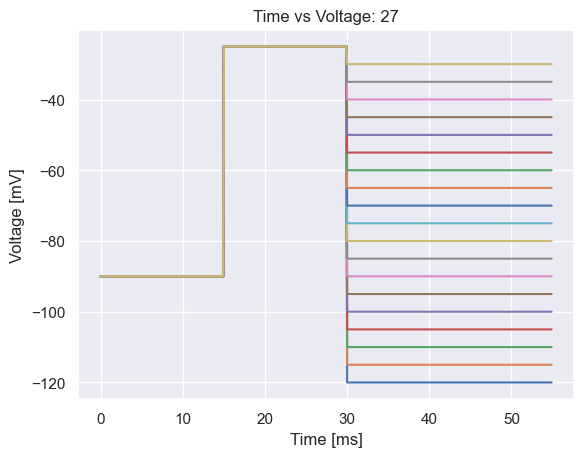

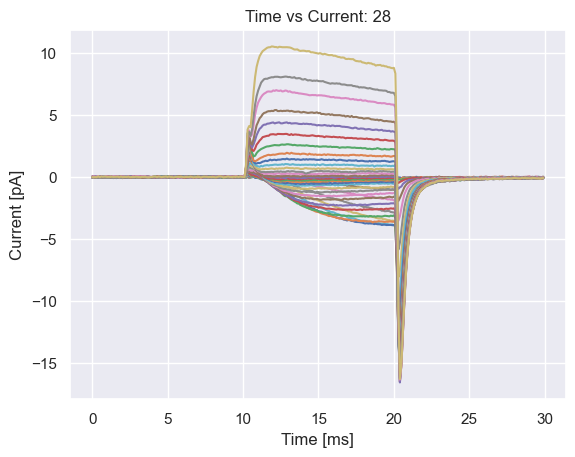

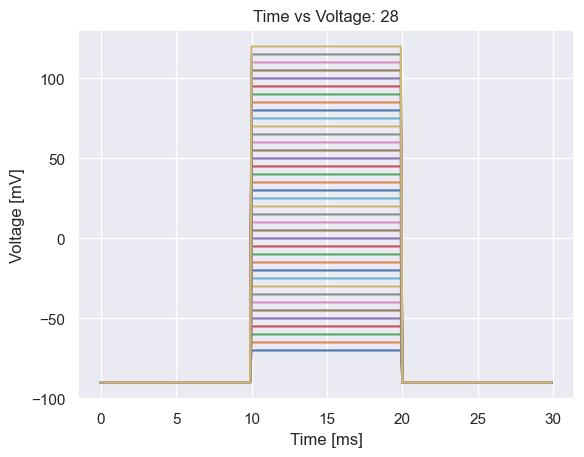

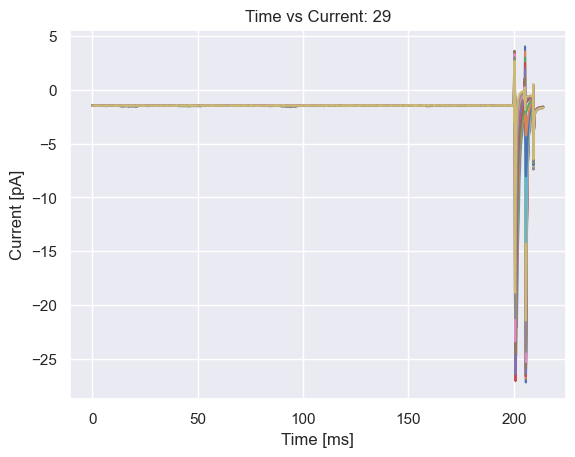

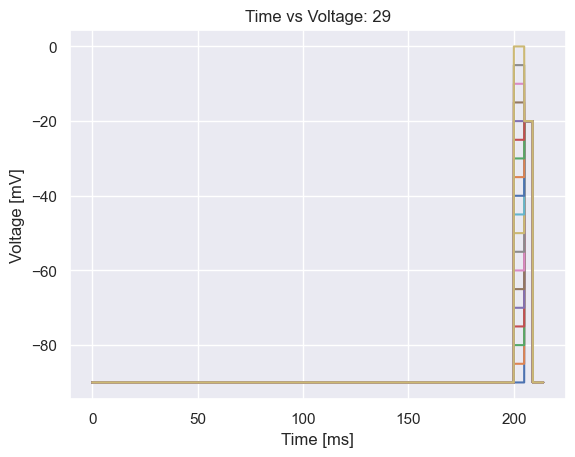

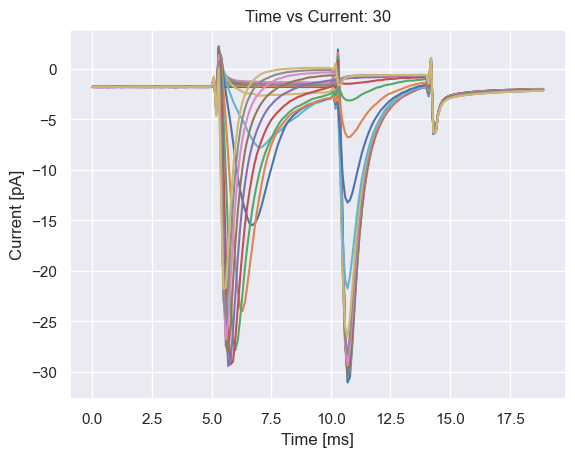

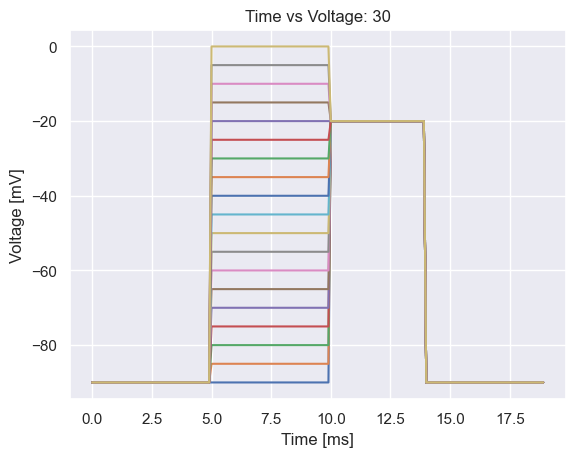

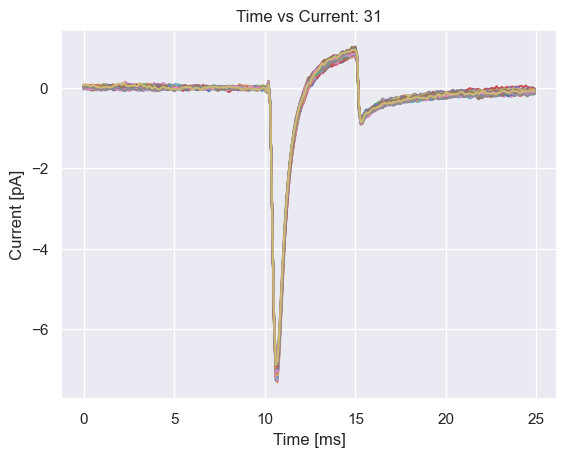

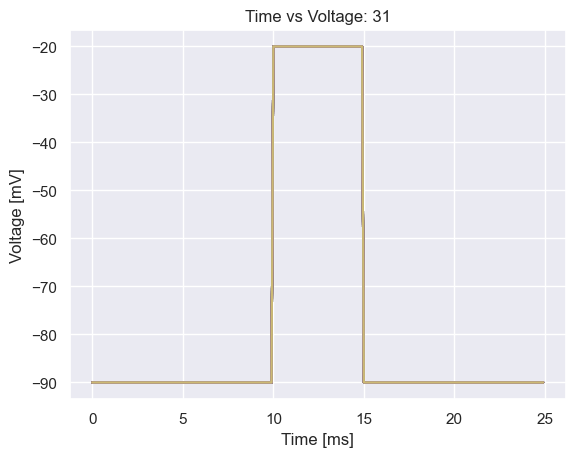

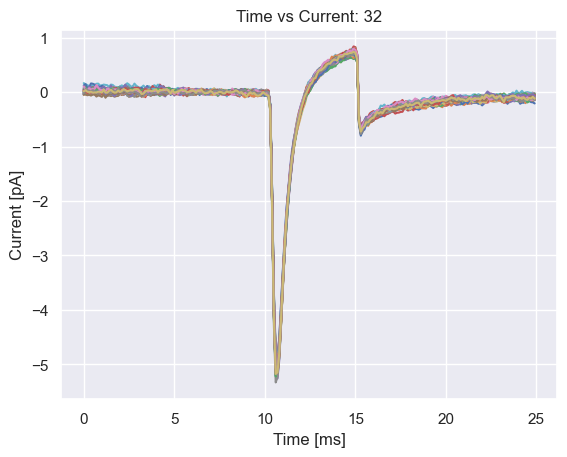

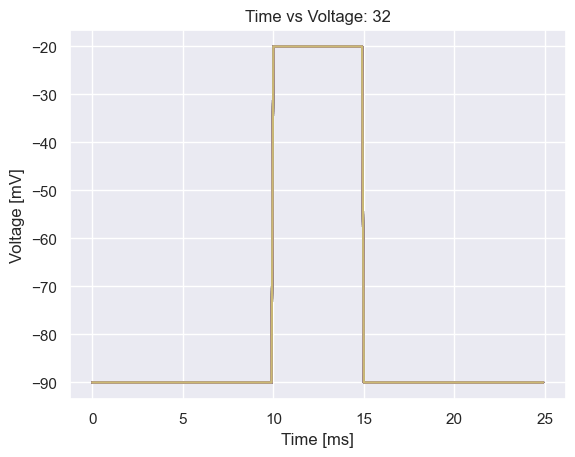

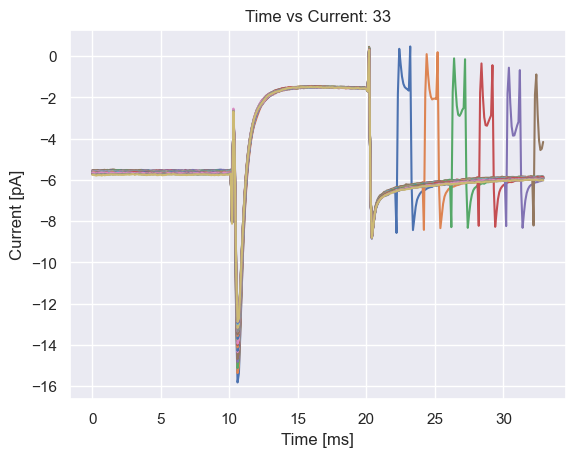

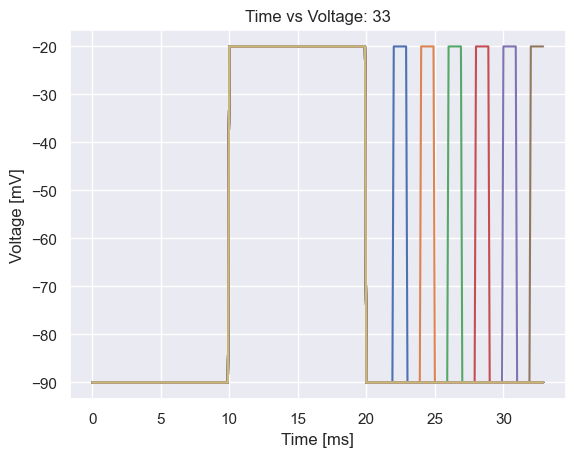

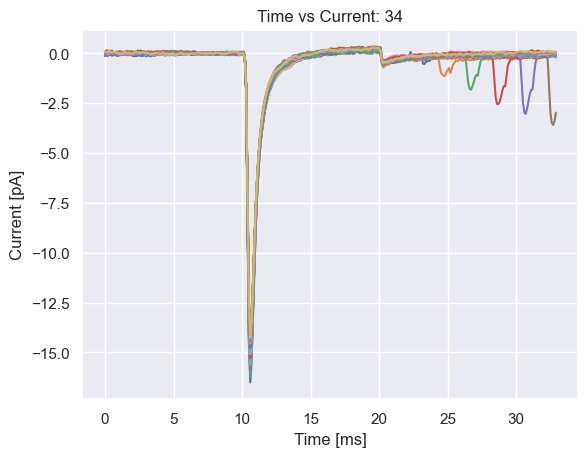

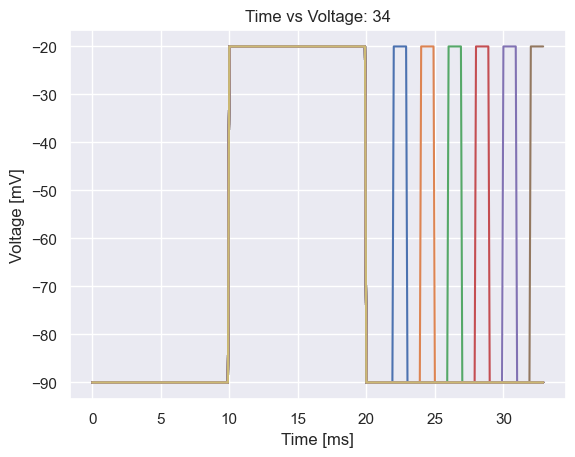

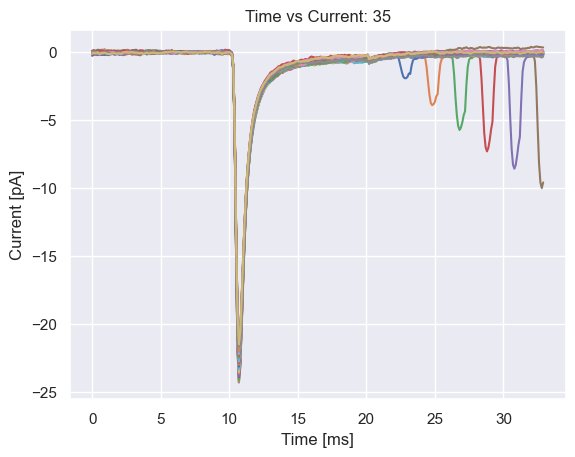

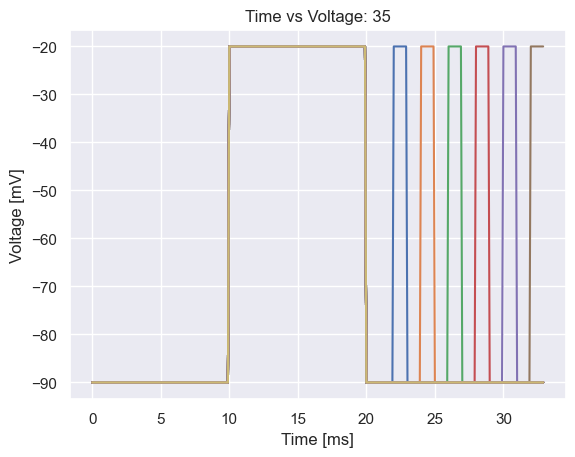

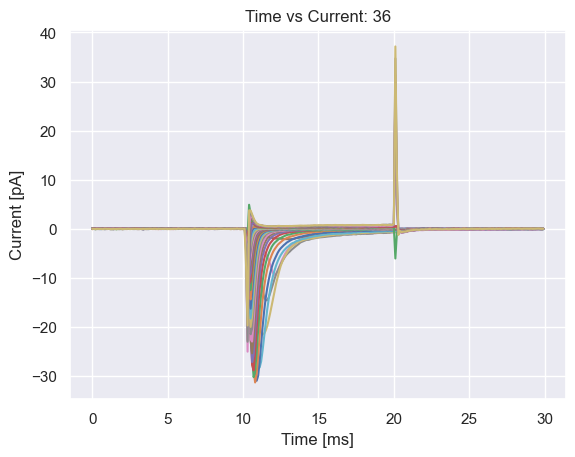

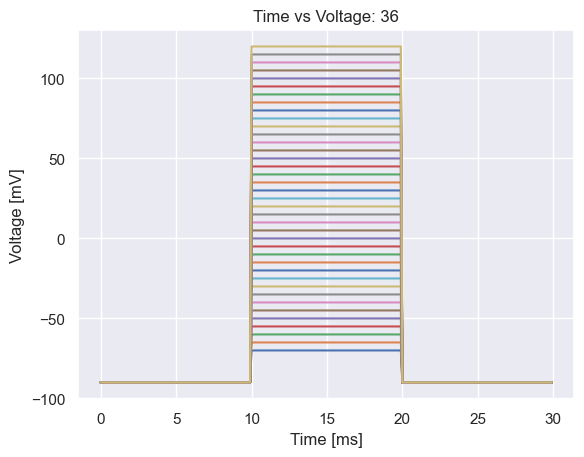

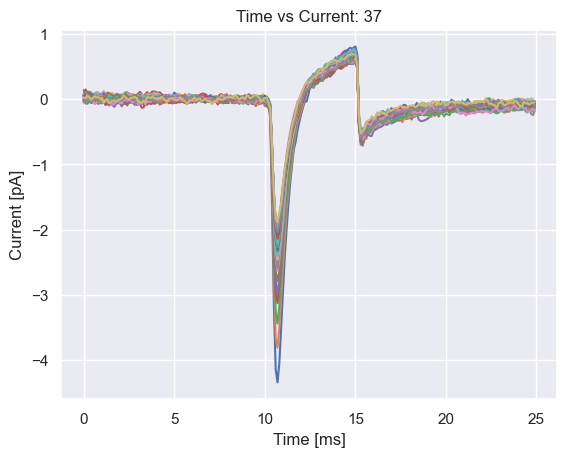

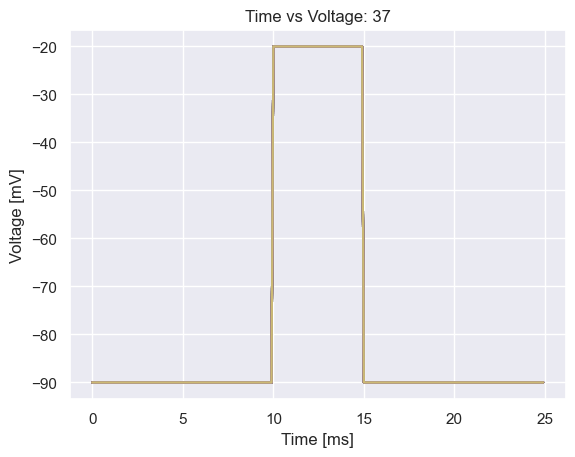

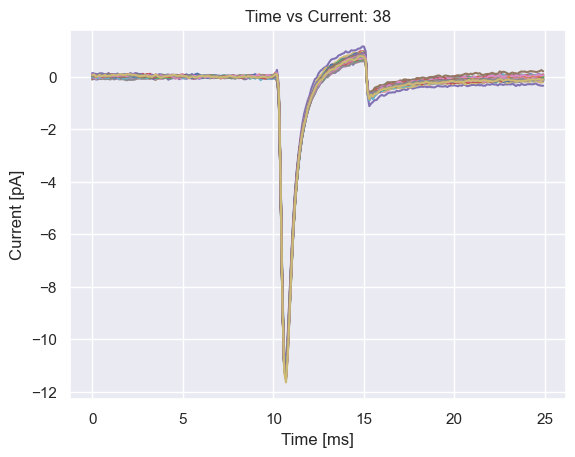

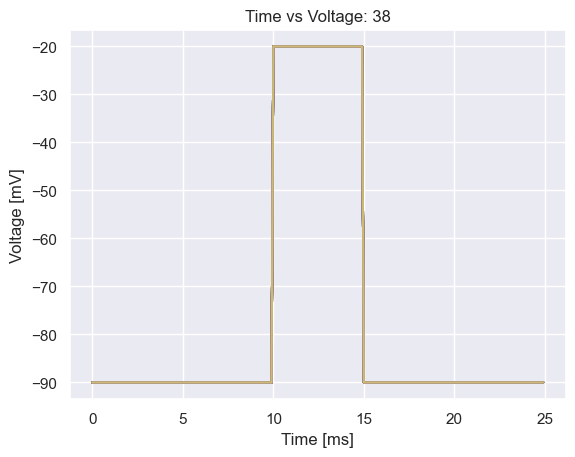

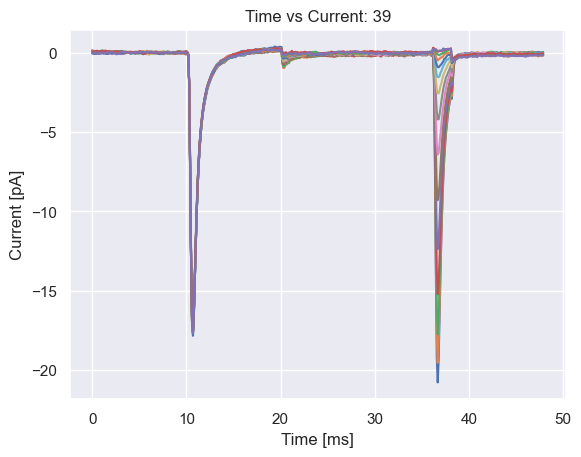

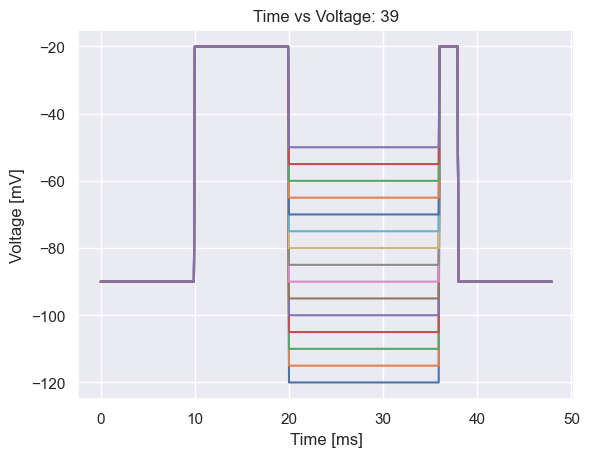

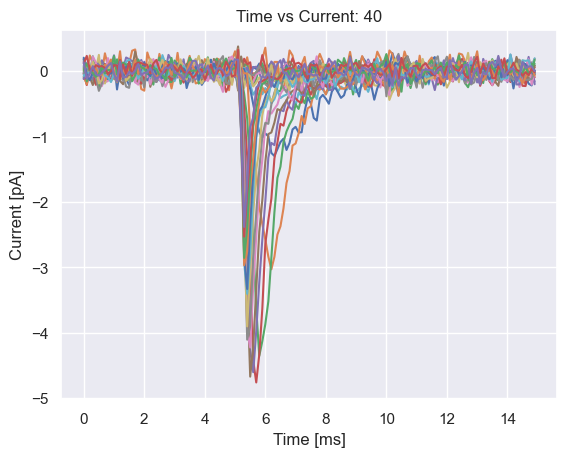

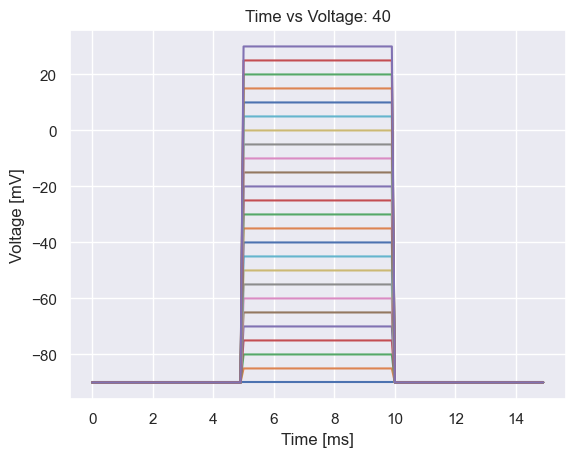

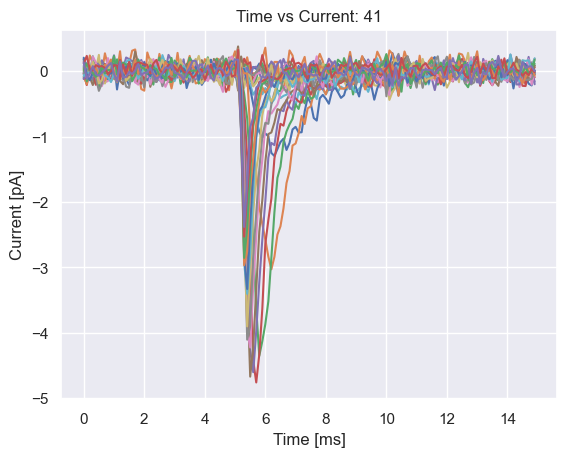

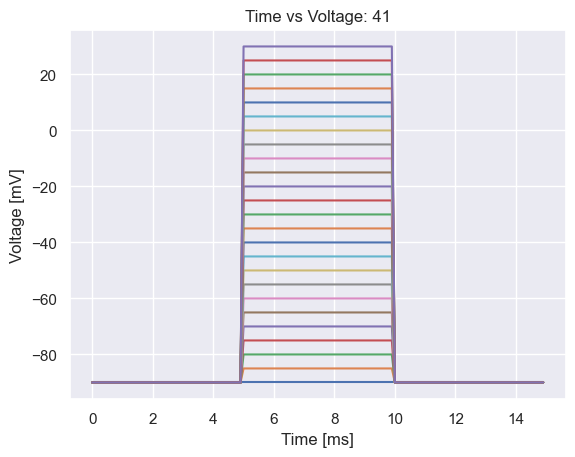

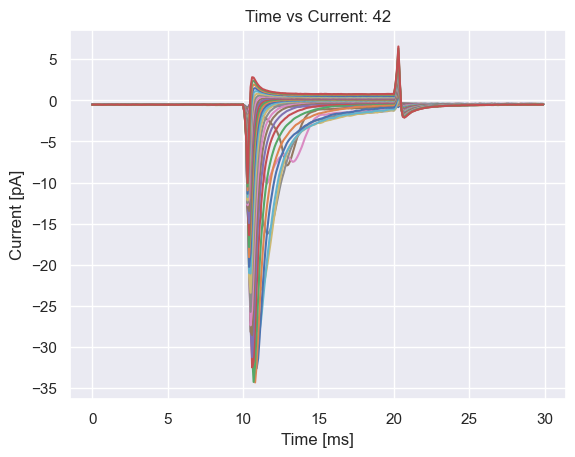

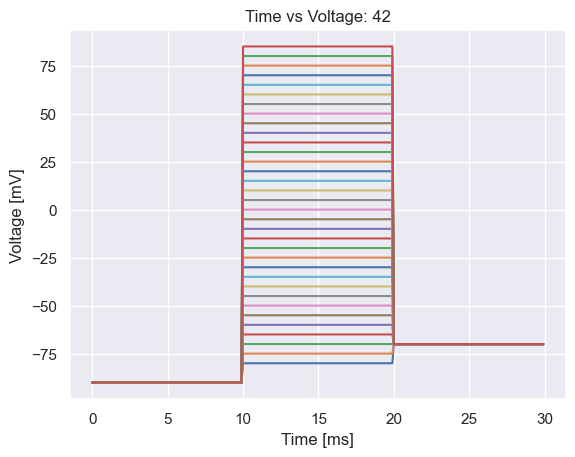

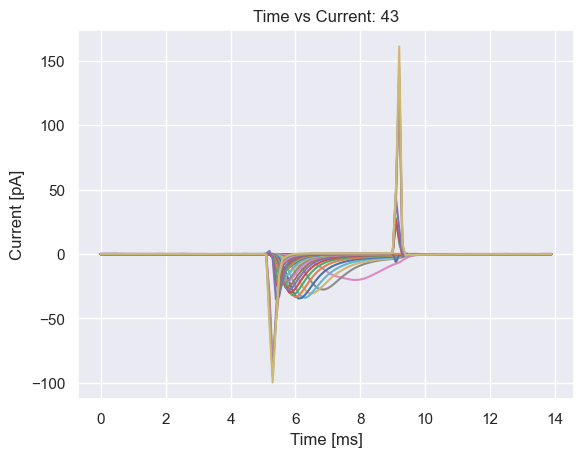

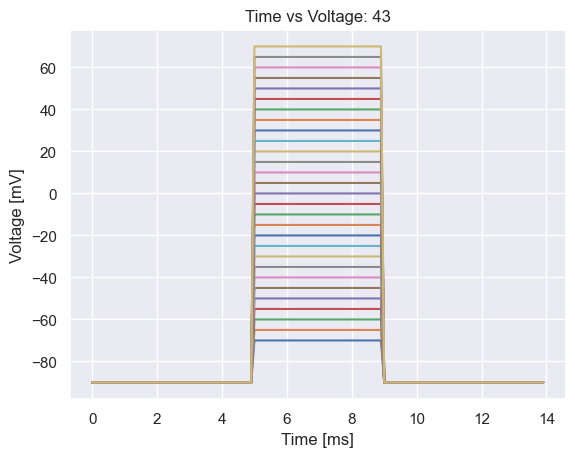

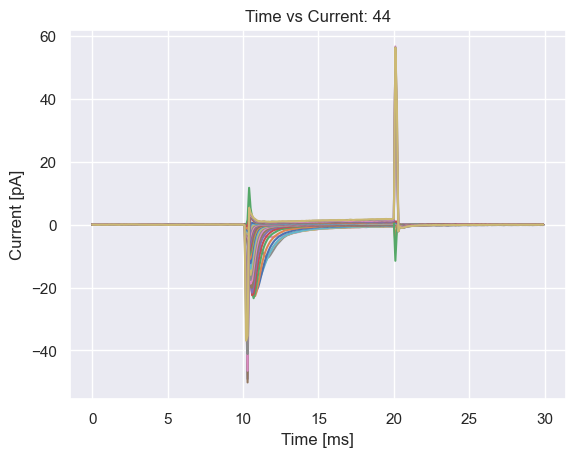

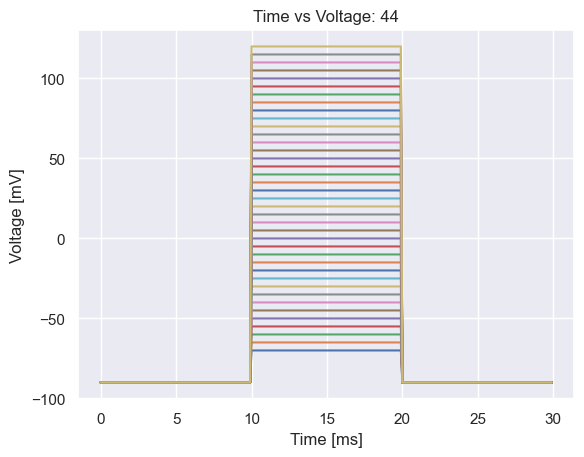

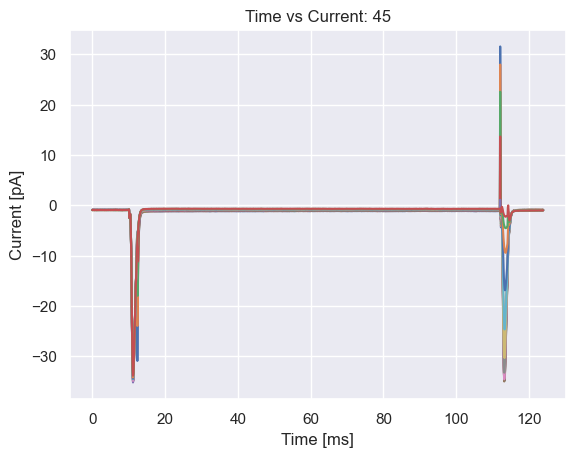

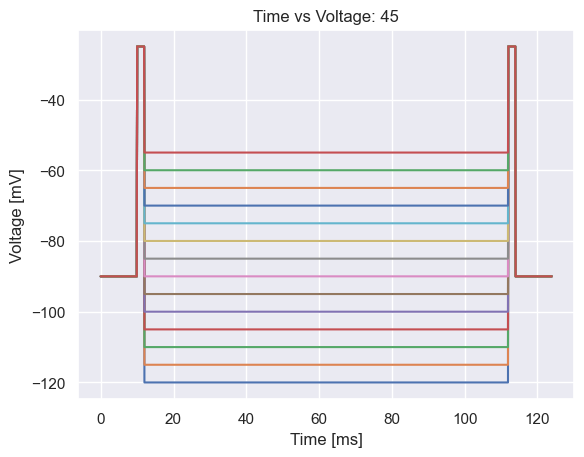

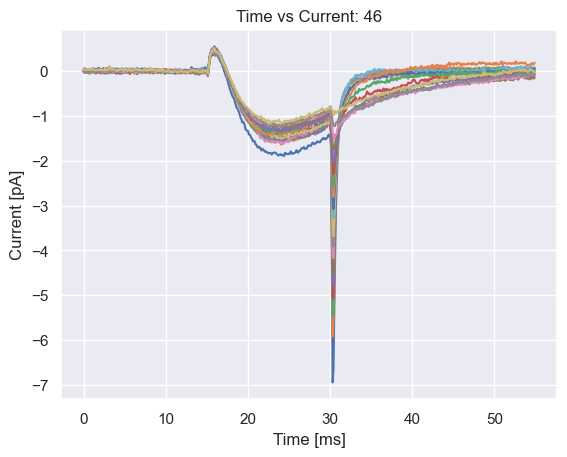

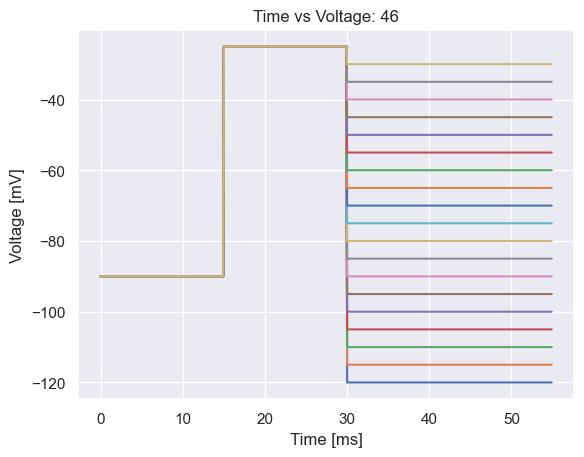

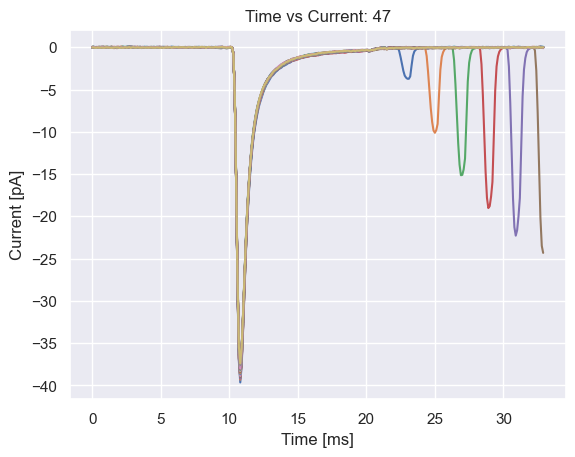

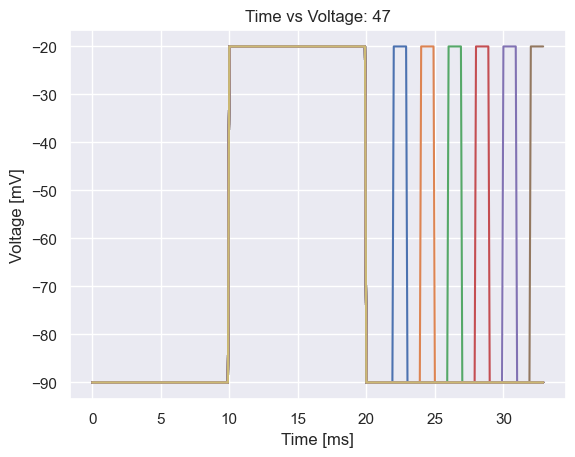

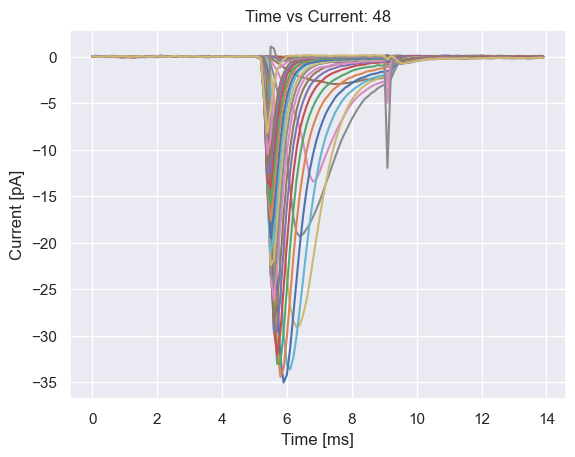

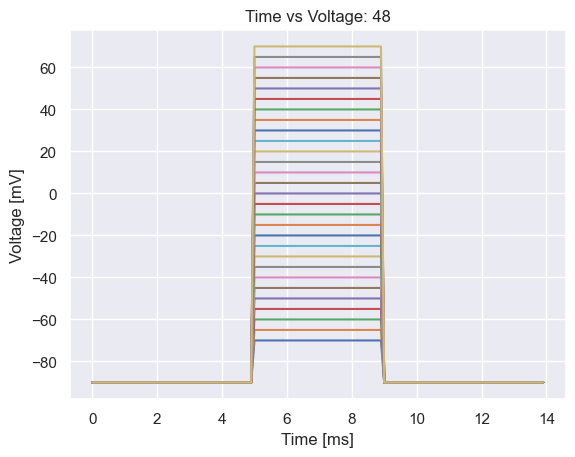

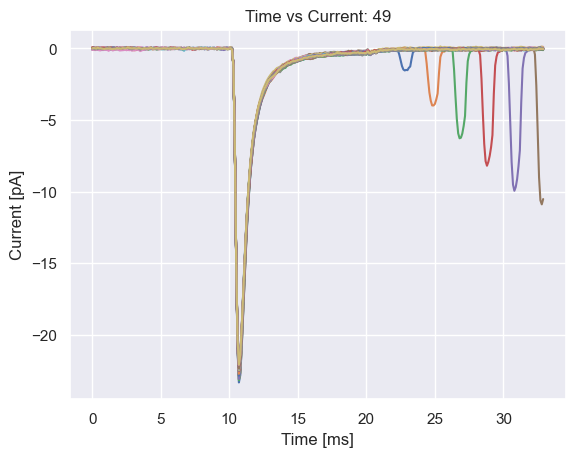

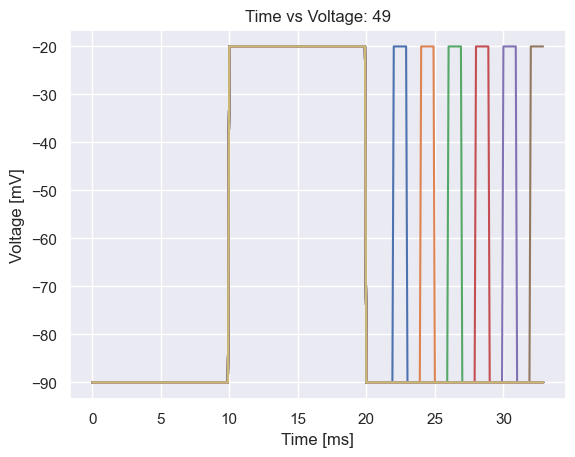

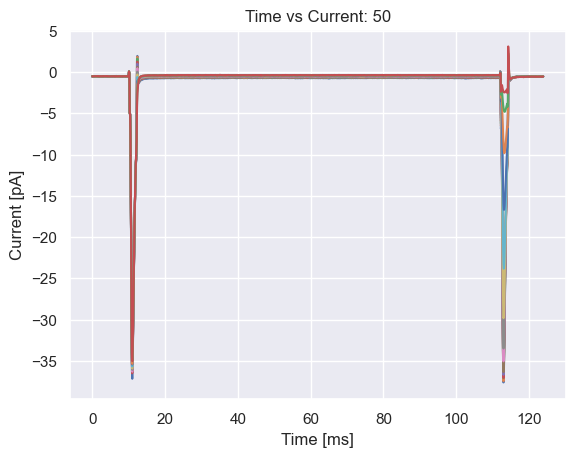

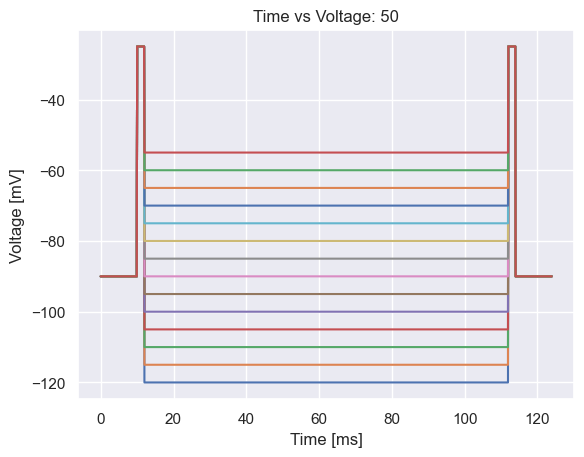

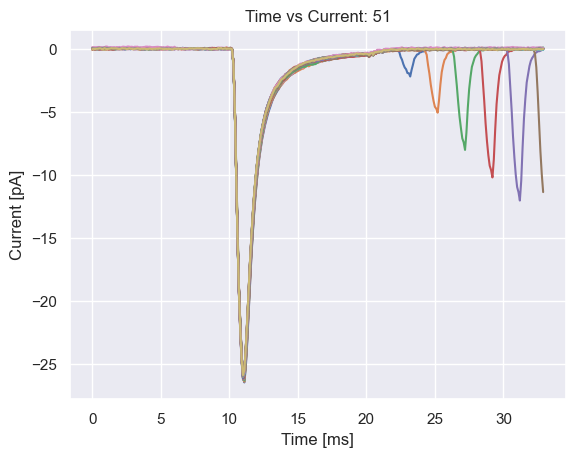

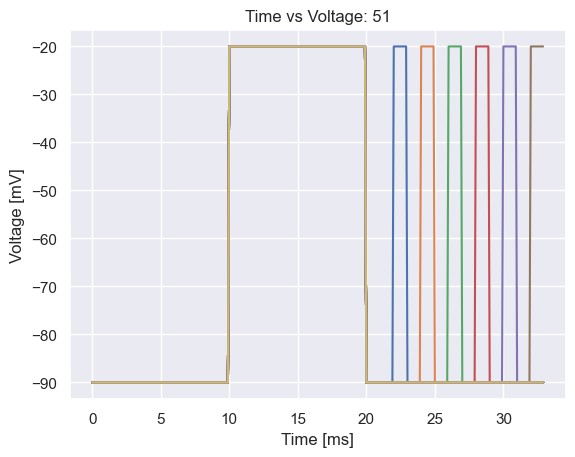

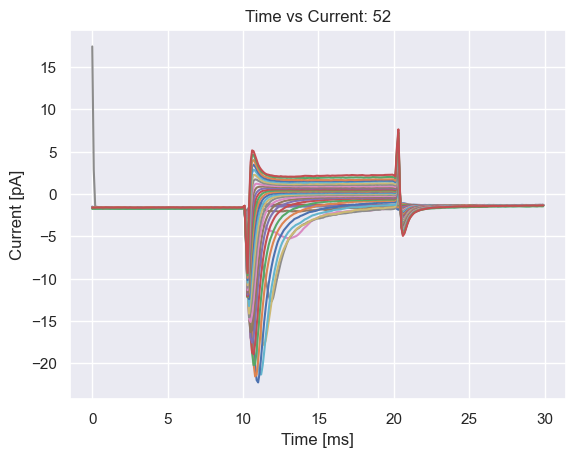

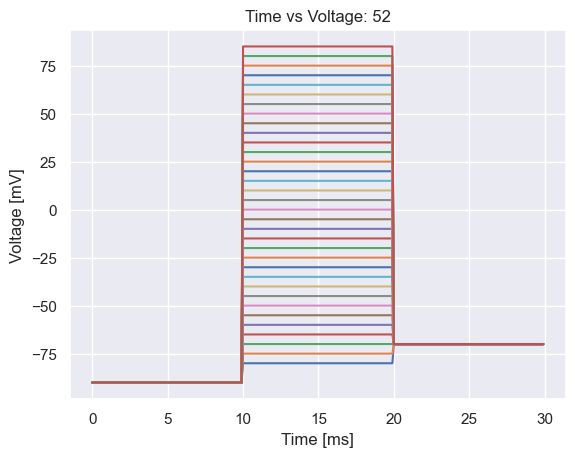

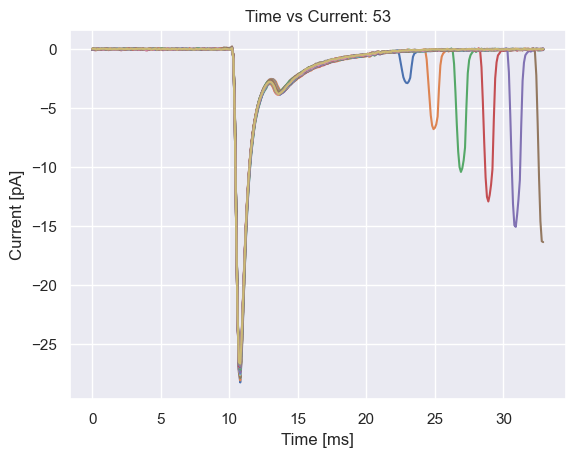

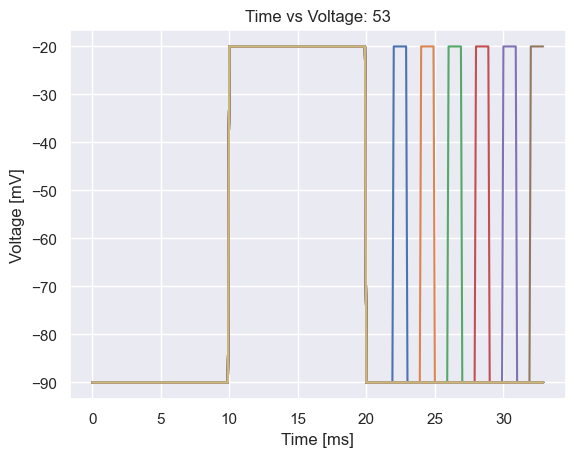

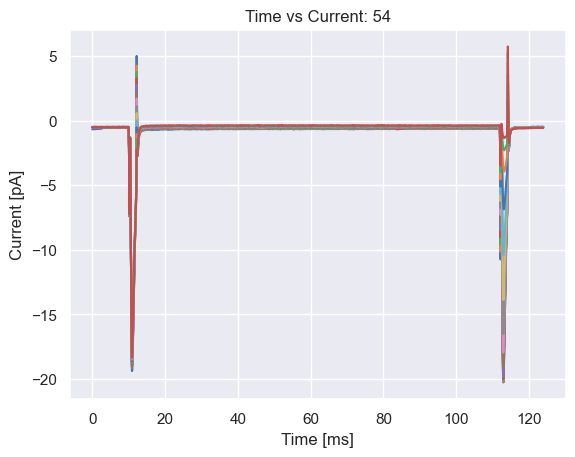

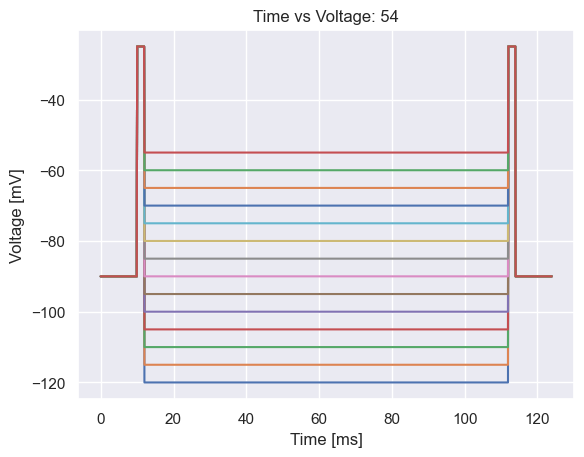

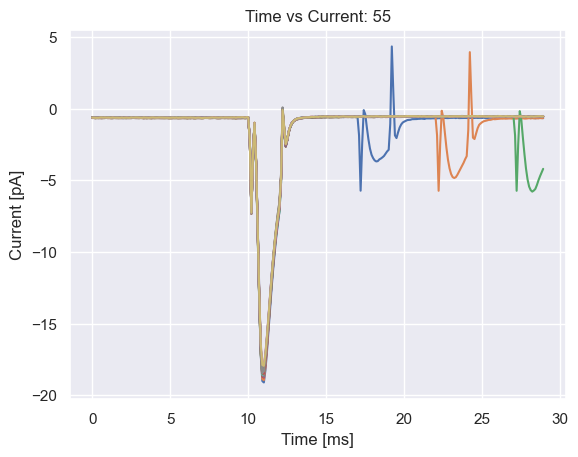

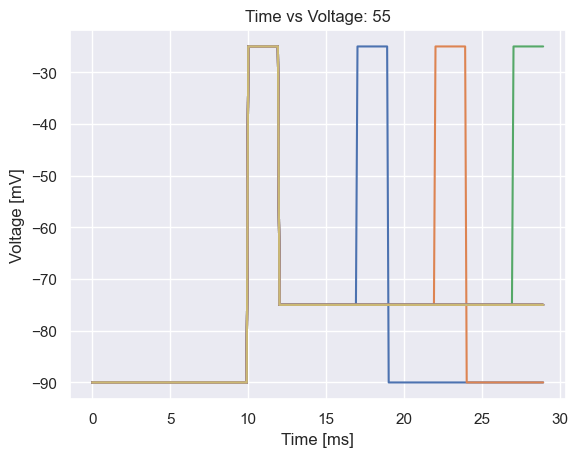

In [8]:
for x in some.keys():
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    for y in range(1, int((some[x]['data'].shape[1]-1)/2)+1):
        ax1.plot(some[x]['data']['Time [ms]'], some[x]['data'].iloc[:, (y*2)-1])
        ax2.plot(some[x]['data']['Time [ms]'], some[x]['data'].iloc[:, (y*2)])
    ax2_title = 'Time vs Voltage: ' + str(x)
    ax1.set_xlabel('Time [ms]')
    ax2.set_xlabel('Time [ms]')
    ax2.set_ylabel('Voltage [mV]')
    ax1.set_ylabel('Current [pA]')
    ax1_title = 'Time vs Current: ' + str(x)
    ax1.set_title(f'{ax1_title}')
    ax2.set_title(f'{ax2_title}')
    plt.show()

## Functions for analysis
Based on the plots we see, we need four different types of analysis:

1. Calculating the inactivation curve based on voltage
2. Calculating the activation curve based on voltage
3. Calculating the re-activation curve based on recovery time
4. Calculating the inactivation curve based on the voltage during the recovery period
5. Calculating the activation curve based on the voltage during the recovery period

To do this, we first need to define the Boltzmann function. This function will be used to calculate the voltage-based inactivation/activation curves. We'll also define an objective function to generate a best-fitting curve for the Boltzmann function.

In [12]:
def boltzmann(V, Imax, V1_2, k):
    return (Imax * (1.0 - 1.0 / (1.0 + np.exp((V - V1_2) / k)))) 
def objective_function(params, x, y):
    Imax, V1_2, k = params
    return np.sum((boltzmann(x, Imax, V1_2, k) - y) ** 2)

Let's now define a function that can calculate an inactivation curve based on voltage. The below function plots the current vs time, voltage vs time, a current-voltage curve (based on the maximum change in current during the voltage change), and an inactivation curve (based on the maximum change during the tail current) using the Boltzmann function.

In [13]:
def inactivation_analysis(some, x):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()


    max_current = []
    voltage_step = []
    inactivation_tail_current = []

    dx = np.diff(some[x]['data'].iloc[:len(some[x]['data'].iloc[:, some[x]['data'].shape[1]-1]), 0])
    dy = np.diff(some[x]['data'].iloc[:, some[x]['data'].shape[1]-1])
    dy_dx = dy / dx
    left = np.argmax(dy_dx)
    right = np.argmin(dy_dx)
    for y in range(1, int((some[x]['data'].shape[1]-1)/2)+1):
        ax1.plot(some[x]['data']['Time [ms]'], some[x]['data'].iloc[:, (y*2)-1])
        ax2.plot(some[x]['data']['Time [ms]'], some[x]['data'].iloc[:, (y*2)]) 
        if y < int((some[x]['data'].shape[1]-1)/2)+1-5:
            current_window = some[x]['data'].iloc[np.argmax(dy_dx):np.argmin(dy_dx), (y*2)-1]
            voltage_window = some[x]['data'].iloc[np.argmax(dy_dx):np.argmin(dy_dx), (y*2)]
            inactivation_tail = some[x]['data'].iloc[np.argmin(dy_dx):np.argmin(dy_dx)+50, (y*2)-1]
            max_current.append(current_window.iloc[np.argmax(np.absolute(current_window))]) 
            voltage_step.append(voltage_window.iloc[np.argmax(np.absolute(current_window))])
            inactivation_tail_current.append(inactivation_tail.iloc[np.argmin(inactivation_tail)])
    inactivation_tail_current = inactivation_tail_current[:np.argmin(inactivation_tail_current)+1]
    
    volt = voltage_step[:len(inactivation_tail_current)]
    
    Imax_guess = np.max(inactivation_tail_current)
    V1_2_guess = np.mean(volt)
    k_guess = 10.0
    
    # set up the optimization problem
    result = optimize.minimize(objective_function, [Imax_guess, V1_2_guess, k_guess], args=(volt, inactivation_tail_current))
    
    # extract the best-fit parameters
    Imax_fit, V1_2_fit, k_fit = result.x
    
    # generate the inactivation curve using the best-fit parameters
    V_range = np.linspace(volt[0], volt[-1], 100)
    I_over_Imax_fit = boltzmann(V_range, Imax_fit, V1_2_fit, k_fit)
    
    
    I_over_Imax_fit = (I_over_Imax_fit - np.min(I_over_Imax_fit)) / (np.max(I_over_Imax_fit) - np.min(I_over_Imax_fit))
    
    inactivation_tail_current = (inactivation_tail_current - np.min(inactivation_tail_current)) / (np.max(inactivation_tail_current) - np.min(inactivation_tail_current))
    
    ax3.plot(voltage_step, max_current)
    ax3.set_title('I/V Curve')
    ax4.plot(volt, inactivation_tail_current, '-', label='Experimental Data')
    ax4.plot(V_range, I_over_Imax_fit, 'o', label = 'Boltzmann fit')
    ax4.set_title('Inactivation Curve')

    ax2_title = 'Time vs Voltage: ' + str(x)
    ax1.set_xlabel('Time [ms]')
    ax2.set_xlabel('Time [ms]')
    ax2.set_ylabel('Voltage [mV]')
    ax1.set_ylabel('Current [pA]')
    ax1_title = 'Time vs Current: ' + str(x)
    ax1.set_title(f'{ax1_title}')
    ax2.set_title(f'{ax2_title}')
    plt.show()
    return voltage_step, max_current, V_range, I_over_Imax_fit, inactivation_tail_current, Imax_fit, V1_2_fit, k_fit

Let's see this in action:

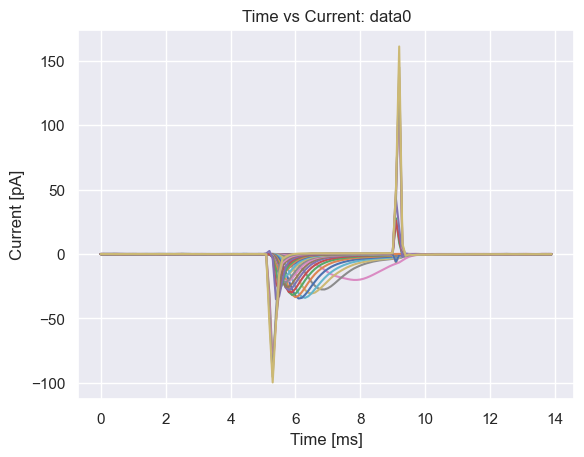

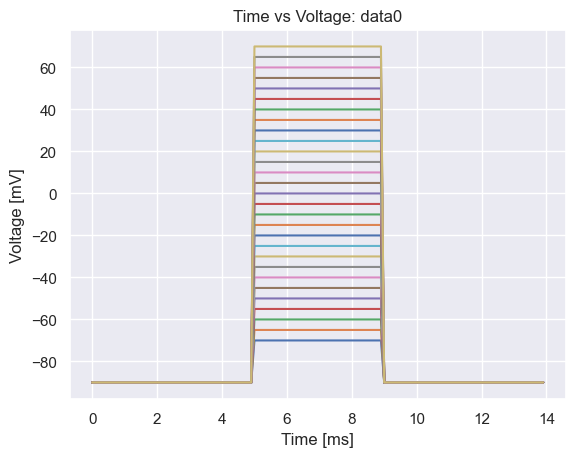

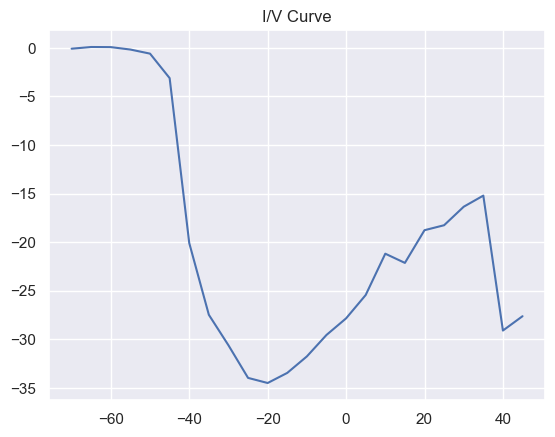

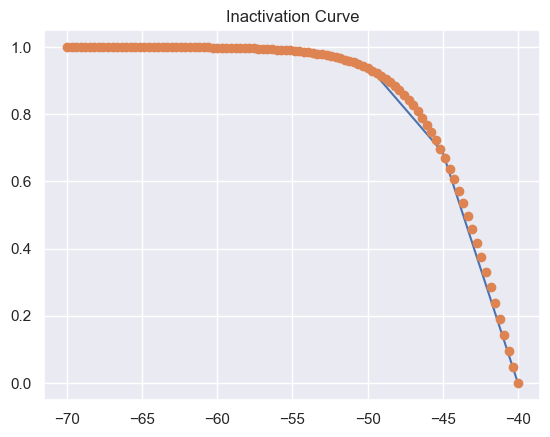

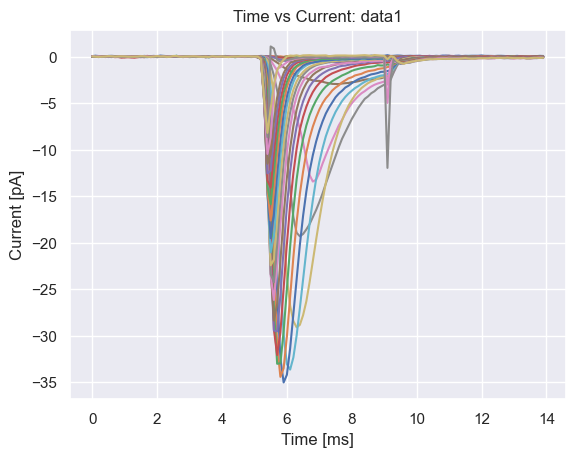

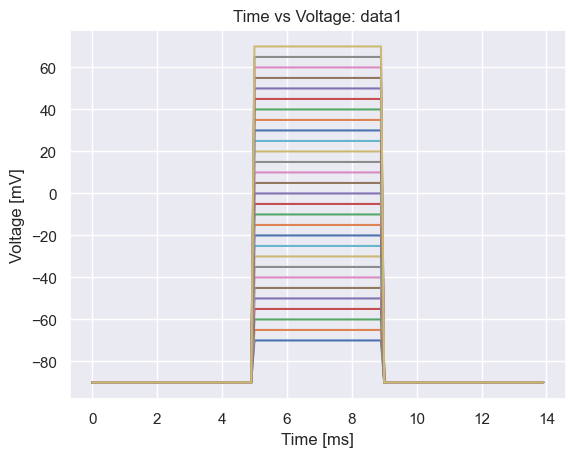

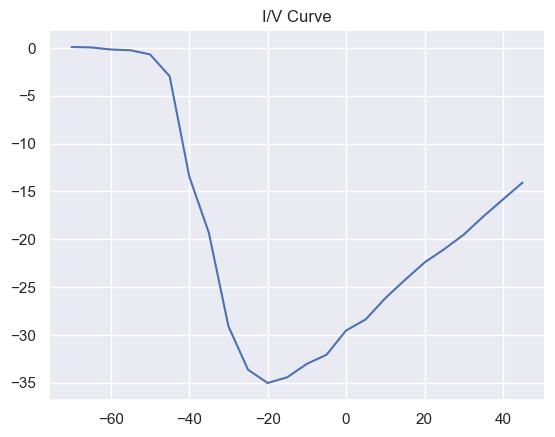

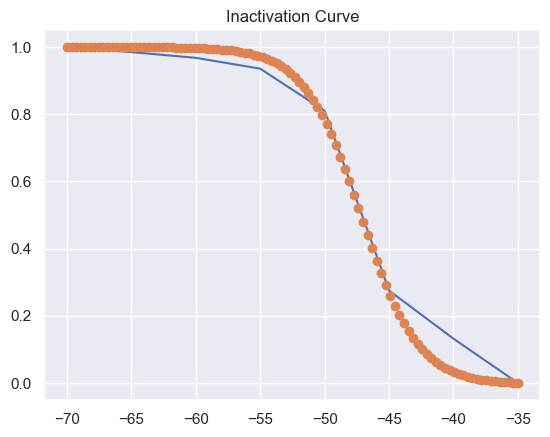

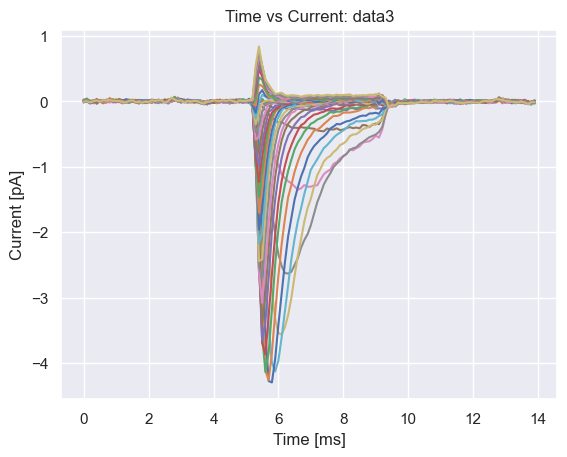

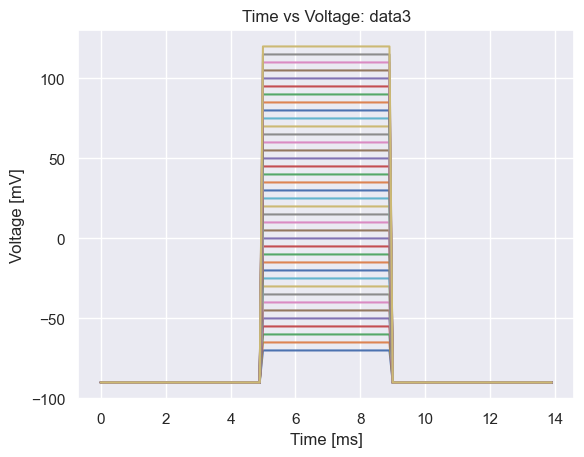

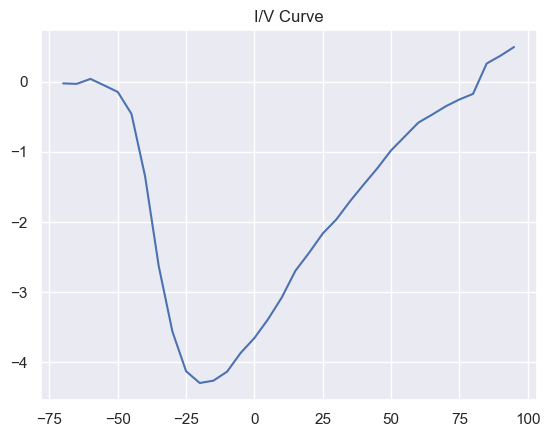

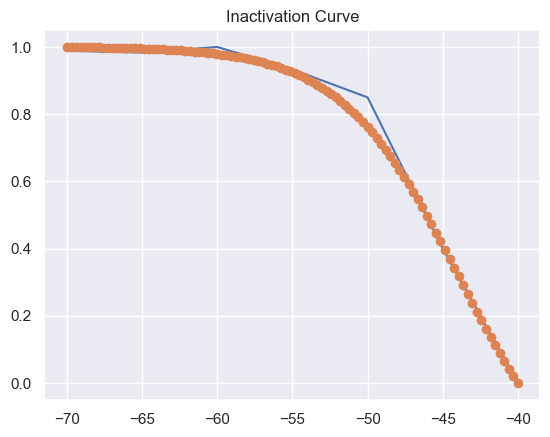

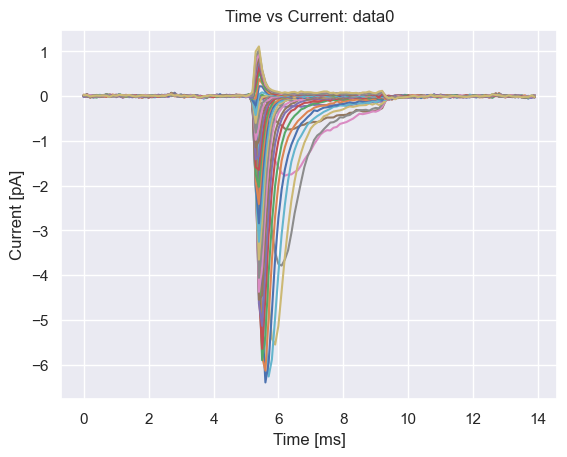

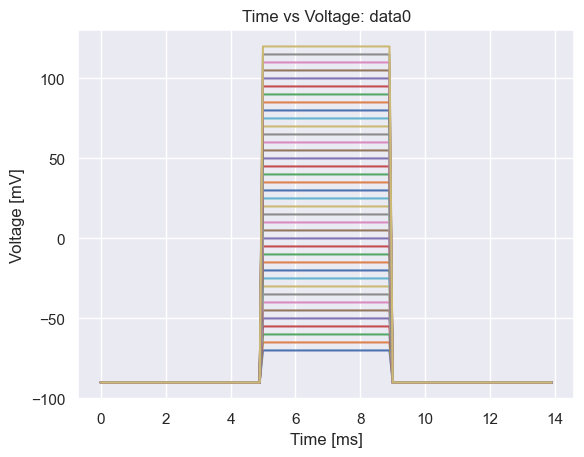

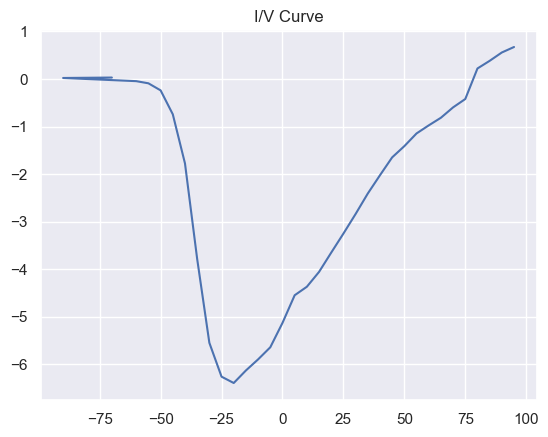

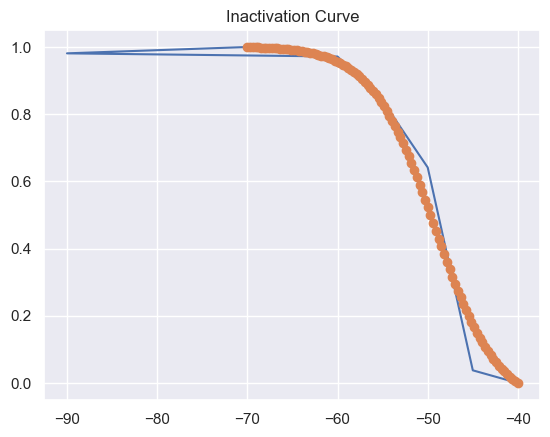

In [17]:
indices = [['239', 'data0'], ['240', 'data1'], ['290', 'data3'], ['292', 'data0']]

for x in indices:
    index = x[0]
    dataset = x[1]
    voltage_step, max_current, V_range, I_over_Imax_fit, activation_tail_current, Imax_fit, V1_2_fit, k_fit = inactivation_analysis(final[index], dataset)

Now let's develop a similar analysis for calculating an activation curve based on voltage. The below function plots the current vs time, voltage vs time, a current-voltage curve (based on the maximum change in current during the voltage change), and an activation curve (based on the maximum change during the tail current-- now looking at the number of channels that have yet to be activated) using the Boltzmann function.

In [18]:
def activation_analysis(some, x):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()

    max_current = []
    voltage_step = []
    activation_tail_current = []

    dx = np.diff(some[x]['data']['Time [ms]'])
    dy = np.diff(some[x]['data'].iloc[:, some[x]['data'].shape[1]-1])
    dy_dx = dy / dx
    sort = np.argsort(dy_dx)
    if dy_dx[sort[1]] < 0:
        if sort[1] > sort[0]:
            idx = sort[0]
            idx2 = sort[1]
        else:
            idx = sort[1]
            idx2 = sort[0]
    else:
        idx = sort[0]
        idx2 = some[x]['data'].shape[0]-5
    for y in range(1, int((some[x]['data'].shape[1]-1)/2)+1):
        ax1.plot(some[x]['data']['Time [ms]'], some[x]['data'].iloc[:, (y*2)-1])
        ax2.plot(some[x]['data']['Time [ms]'], some[x]['data'].iloc[:, (y*2)])

        current_window = some[x]['data'].iloc[np.argmax(dy_dx):idx, (y*2)-1]
        voltage_window = some[x]['data'].iloc[np.argmax(dy_dx):idx, (y*2)]
        activation_tail = some[x]['data'].iloc[idx:idx2, (y*2)-1]
        max_current.append(current_window.iloc[np.argmax(np.absolute(current_window))]) 
        voltage_step.append(voltage_window.iloc[np.argmax(np.absolute(current_window))])
        activation_tail_current.append(activation_tail.iloc[np.argmin(activation_tail)])
    activation_tail_current = activation_tail_current[np.argmax(activation_tail_current):]
    volt = voltage_step[:len(activation_tail_current)]
    Imax_guess = np.max(activation_tail_current)
    V1_2_guess = np.mean(volt)
    k_guess = 10.0
    
    # set up the optimization problem
    result = optimize.minimize(objective_function, [Imax_guess, V1_2_guess, k_guess], args=(volt, activation_tail_current))
    
    # extract the best-fit parameters
    Imax_fit, V1_2_fit, k_fit = result.x
    
    # generate the inactivation curve using the best-fit parameters
    V_range = np.linspace(volt[0], volt[-1], 100)
    I_over_Imax_fit = boltzmann(V_range, Imax_fit, V1_2_fit, k_fit)
    I_over_Imax_fit = 1-(I_over_Imax_fit - np.min(I_over_Imax_fit)) / (np.max(I_over_Imax_fit) - np.min(I_over_Imax_fit))
    
    activation_tail_current = 1-(activation_tail_current - np.min(activation_tail_current)) / (np.max(activation_tail_current) - np.min(activation_tail_current))
    
    
    
    ax3.plot(voltage_step, max_current)
    ax3.set_title('I/V Curve')
    ax4.plot(volt, activation_tail_current, '-', label='Experimental Data')
    ax4.plot(V_range, I_over_Imax_fit, 'o', label = 'Boltzmann fit')
    ax4.set_title('Activation Curve')
    
    ax2_title = 'Time vs Voltage: ' + str(x)
    ax1.set_xlabel('Time [ms]')
    ax2.set_xlabel('Time [ms]')
    ax2.set_ylabel('Voltage [mV]')
    ax1.set_ylabel('Current [pA]')
    ax1_title = 'Time vs Current: ' + str(x)
    ax1.set_title(f'{ax1_title}')
    ax2.set_title(f'{ax2_title}')
    plt.show()
    return voltage_step, max_current, V_range, I_over_Imax_fit, activation_tail_current, Imax_fit, V1_2_fit, k_fit

Let's see this function in action as well:

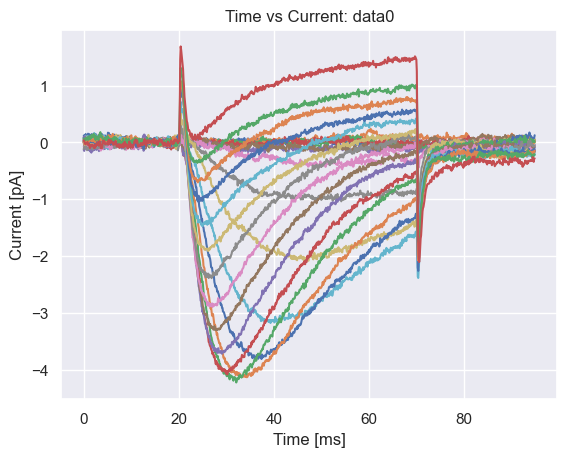

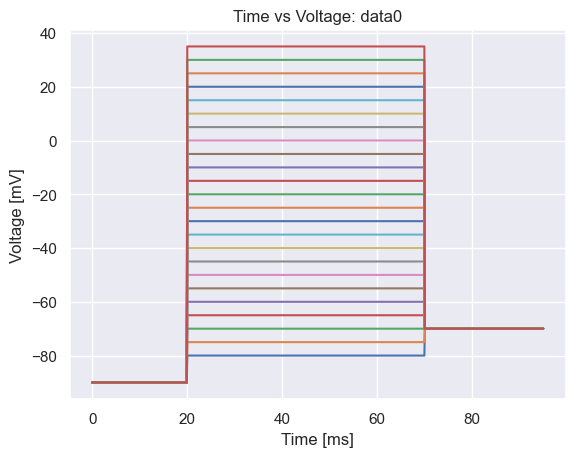

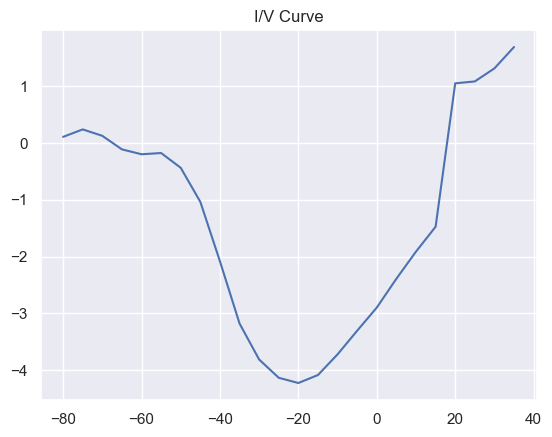

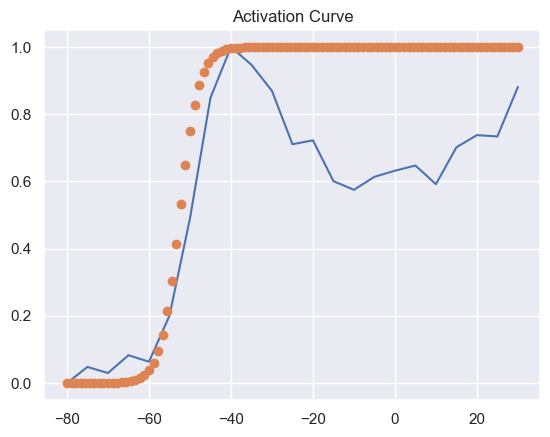

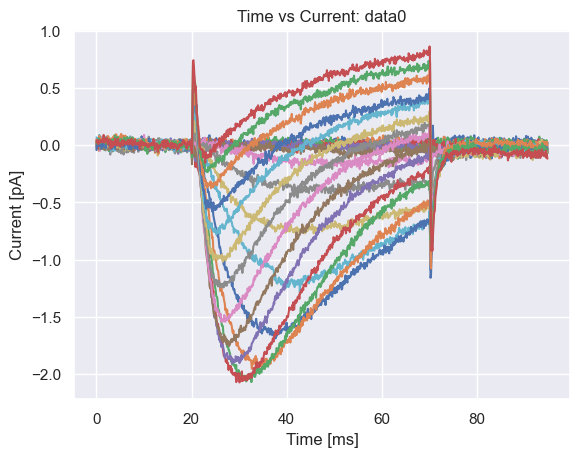

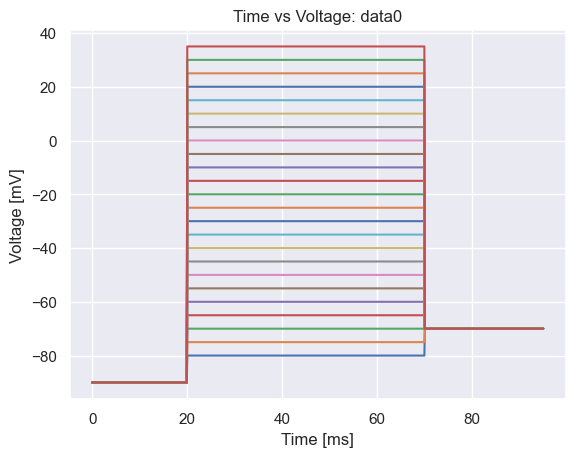

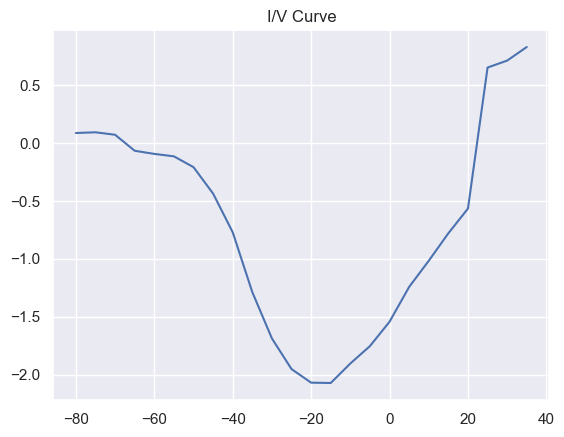

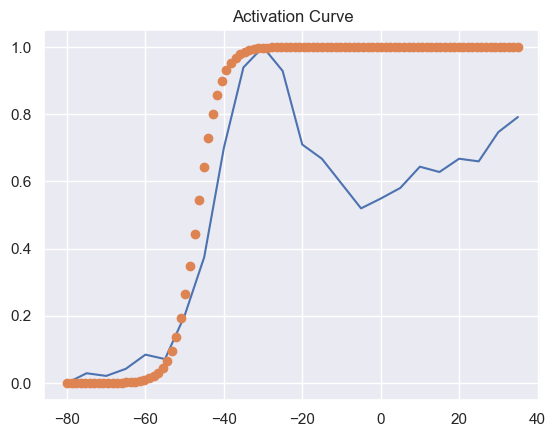

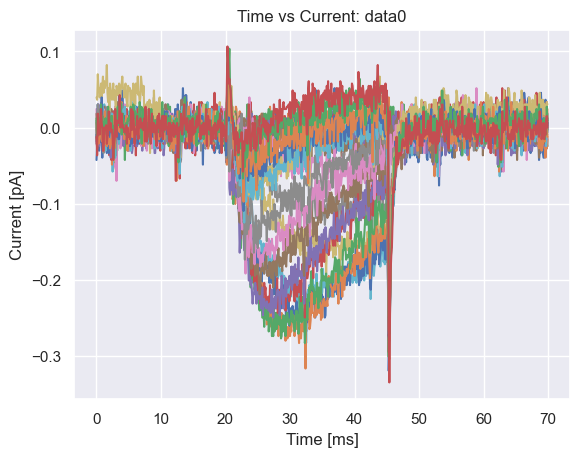

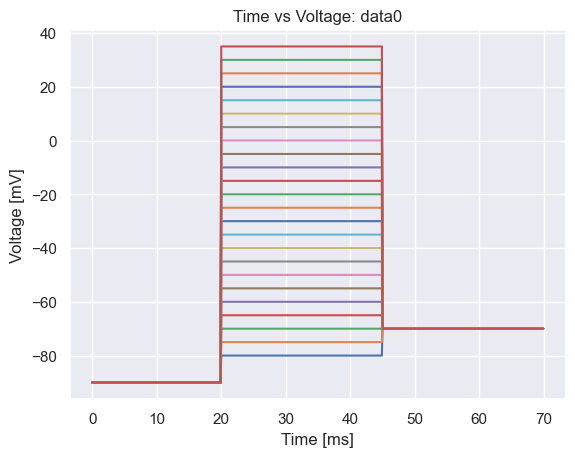

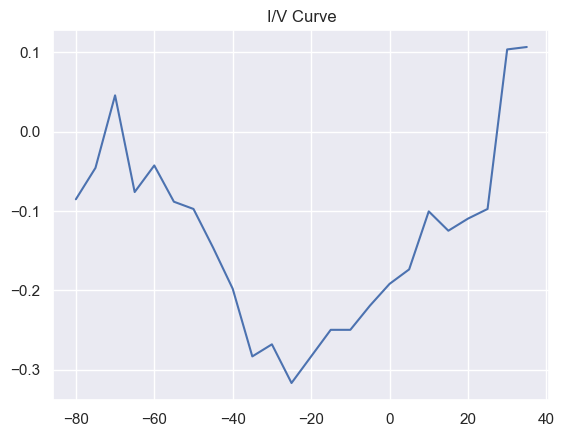

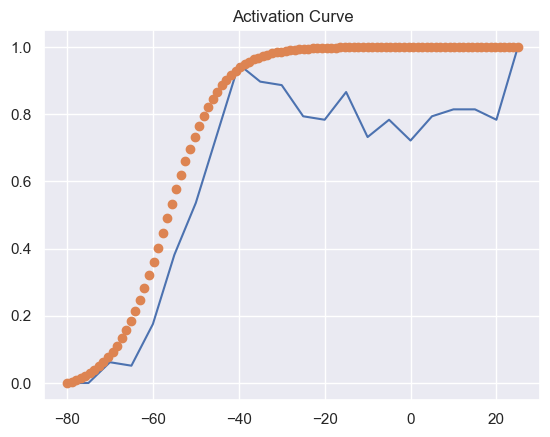

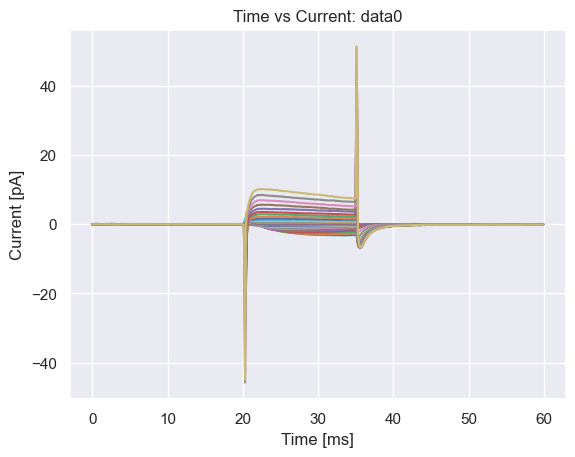

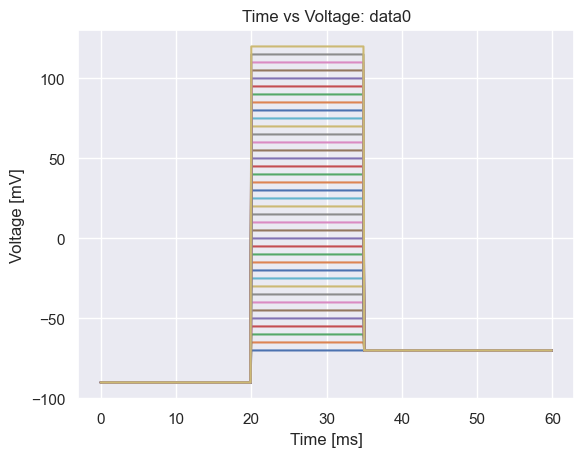

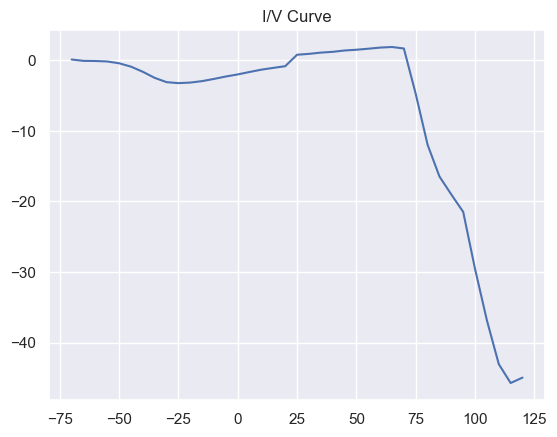

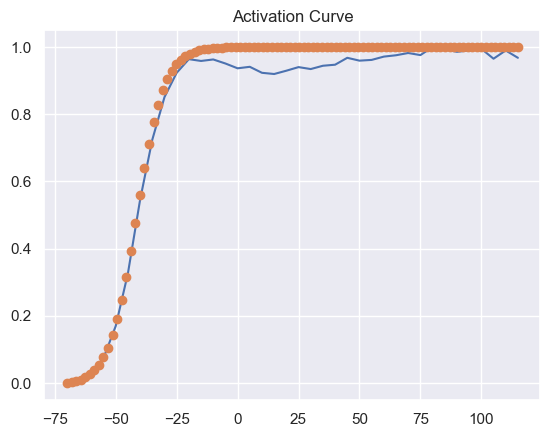

In [19]:
indices = ['288', '287', '277', '212']

for x in indices:
    voltage_step, max_current, V_range, I_over_Imax_fit, activation_tail_current, Imax_fit, V1_2_fit, k_fit = activation_analysis(final[x], 'data0')

Now let's develop some analysis for calculating an inactivation curve based on time. The below function plots the current vs time, voltage vs time, and an activation curve (based on the maximum change during the tail current-- looking at the differences in recovery time) using the Boltzmann function.

In [26]:
def time_inactivation_analysis(some, x):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    sampling = np.mean(np.diff(some[x]['data']['Time [ms]'][:10]))
    
    inactivation_time = []

    max_current = []
    
    for y in range(1, int((some[x]['data'].shape[1]-1)/2)+1):
        nan_indices = np.isnan(some[x]['data'].iloc[:, (y*2)-1])
        first_nan_index = np.argmax(nan_indices)
        time = np.linspace(0, (first_nan_index-1)*sampling, first_nan_index)
        new_current = some[x]['data'].iloc[:first_nan_index, (y*2)-1]
        new_voltage = some[x]['data'].iloc[:first_nan_index, (y*2)]
        ax1.plot(time, new_current)
        ax2.plot(time, new_voltage)
        dx = np.diff(time)
        dy = np.diff(new_voltage)
        dy_dx = dy / dx
        sort = np.argsort(dy_dx)
        if sort[1] > sort[0]:
            first_end = sort[0]
            second_end = sort[1]
        else:
            first_end = sort[1]
            second_end = sort[0]
        if sort[-1] > sort[-2]:
            first_start = sort[-2]
            second_start = sort[-1]
        else:
            first_start = sort[-1]
            second_start = sort[-2]
        inactivation_time.append(second_start-first_end)
        current_window = new_current[second_start:second_end]
        max_current.append(current_window.iloc[np.argmax(np.absolute(current_window))]) 
    max_current = 1-(max_current - np.min(max_current)) / (np.max(max_current) - np.min(max_current))
    # perform a curve fit to a logarithmic curve
    coeffs = np.polyfit(inactivation_time, max_current, 3)

    # create a new x array for plotting the fitted curve
    xfit = np.linspace(inactivation_time[0], inactivation_time[-1], 100)
    yfit = coeffs[0]*xfit**3 + coeffs[1]*xfit**2 + coeffs[2]*xfit + coeffs[3]
    
    ax3.plot(inactivation_time, max_current)
    ax3.plot(xfit, yfit, 'o')
    ax3.set_title('Current vs Time Curve')
    ax2_title = 'Time vs Voltage: ' + str(x)
    ax1.set_xlabel('Time [ms]')
    ax2.set_xlabel('Time [ms]')
    ax2.set_ylabel('Voltage [mV]')
    ax1.set_ylabel('Current [pA]')
    ax1_title = 'Time vs Current: ' + str(x)
    ax1.set_title(f'{ax1_title}')
    ax2.set_title(f'{ax2_title}')
    plt.show()
    return inactivation_time, max_current, xfit, yfit

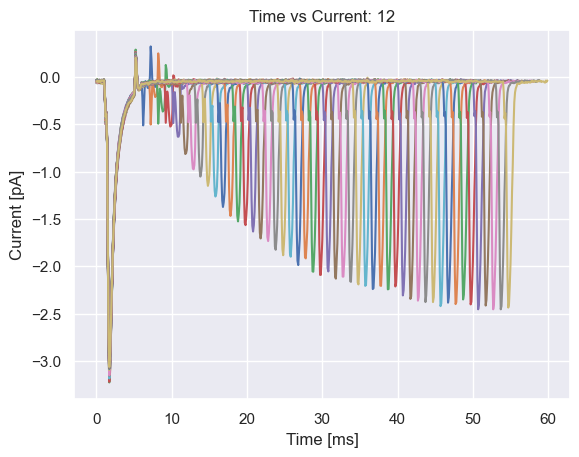

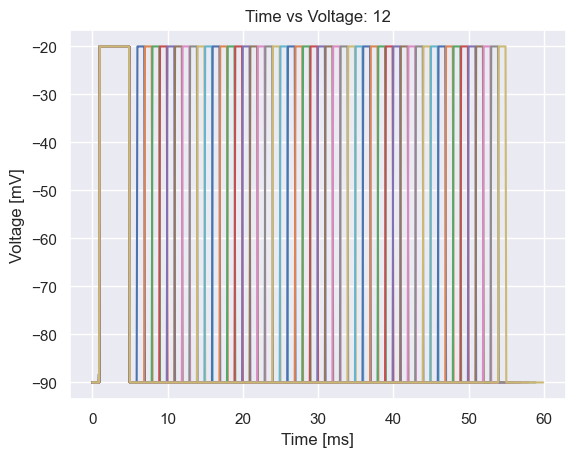

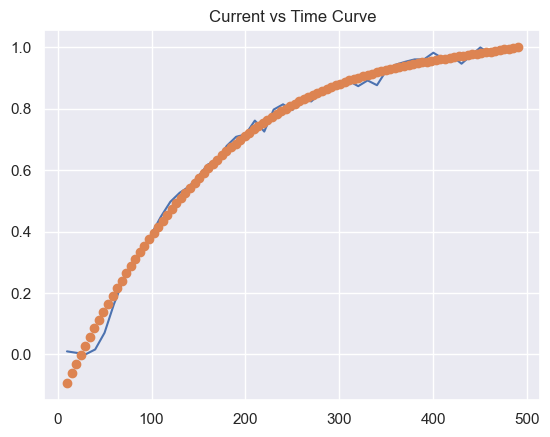

In [27]:
inactivation_time, max_current, xfit, yfit = time_inactivation_analysis(some, 12)

Here's a function for calculating an inactivation curve based on voltage during recovery time. The cell is initially depolarized, then allowed to recovery at varying voltages, then depolarized again. The below function plots the current vs time, voltage vs time, and current-voltage plot (based on the maximum change when depolarized the second time after varying voltages for recovery).

In [30]:
def voltage_inactivation_analysis(some, x):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    sampling = np.mean(np.diff(some[x]['data']['Time [ms]'][:10]))
    
    voltage_step = []

    max_current = []
    
    for y in range(1, int((some[x]['data'].shape[1]-1)/2)+1):
        time = some[x]['data']['Time [ms]']
        new_current = some[x]['data'].iloc[:, (y*2)-1]
        new_voltage = some[x]['data'].iloc[:, (y*2)]
        ax1.plot(time, new_current)
        ax2.plot(time, new_voltage)
        dx = np.diff(time)
        dy = np.diff(new_voltage)
        dy_dx = dy / dx
        sort = np.argsort(dy_dx)
        if sort[1] > sort[0]:
            first_end = sort[0]
            second_end = sort[1]
        else:
            first_end = sort[1]
            second_end = sort[0]
        if sort[-1] > sort[-2]:
            first_start = sort[-2]
            second_start = sort[-1]
        else:
            first_start = sort[-1]
            second_start = sort[-2]
        if first_end > second_start:
            temp_second_start = second_start
            temp_first_end = first_end
            first_end = temp_second_start
            second_start = temp_first_end
        
        voltage_step.append(np.mean(new_voltage[first_end:second_start]))
        current_window = new_current[second_start:second_end]
        max_current.append(current_window.iloc[np.argmin(current_window)]) 
    max_current = 1-(max_current - np.min(max_current)) / (np.max(max_current) - np.min(max_current))
    # perform a curve fit to a logarithmic curve
    coeffs = np.polyfit(voltage_step, max_current, 3)

    # create a new x array for plotting the fitted curve
    xfit = np.linspace(voltage_step[0], voltage_step[-1], 100)
    yfit = coeffs[0]*xfit**3 + coeffs[1]*xfit**2 + coeffs[2]*xfit + coeffs[3]
    
    ax3.plot(voltage_step, max_current)
    ax3.plot(xfit, yfit, 'o')
    ax3.set_title('Current vs Inactivation Voltage Curve')
    ax2_title = 'Time vs Voltage: ' + str(x)
    ax1.set_xlabel('Time [ms]')
    ax2.set_xlabel('Time [ms]')
    ax2.set_ylabel('Voltage [mV]')
    ax1.set_ylabel('Current [pA]')
    ax1_title = 'Time vs Current: ' + str(x)
    ax1.set_title(f'{ax1_title}')
    ax2.set_title(f'{ax2_title}')
    plt.show()
    return voltage_step, max_current, xfit, yfit

Seeing this in action:

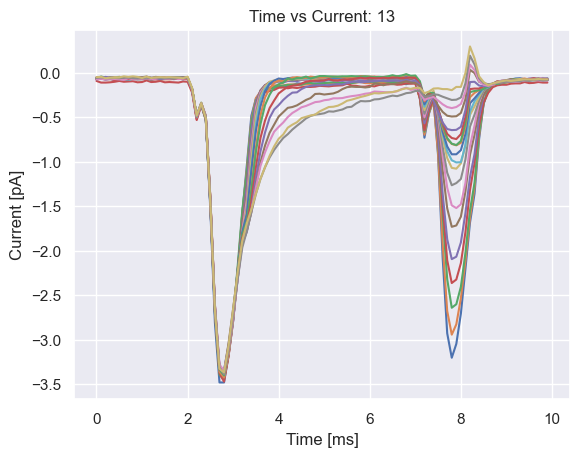

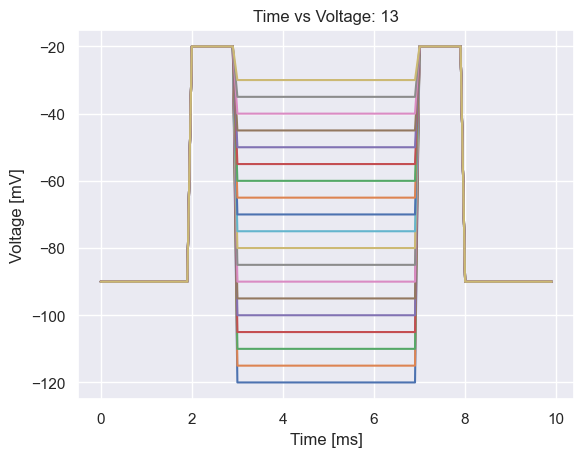

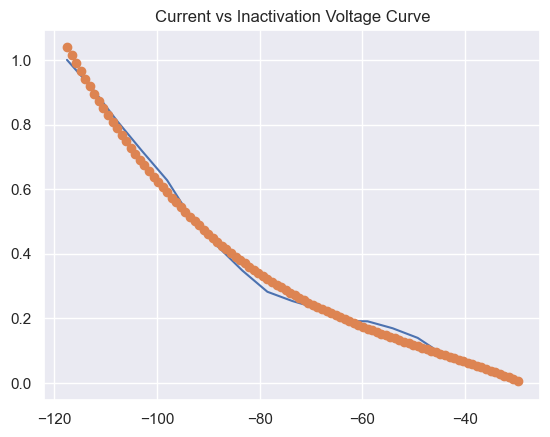

([-117.49999737367034,
  -112.62499475851655,
  -107.74999940767884,
  -102.87499679252505,
  -97.99999417737126,
  -93.12499882653356,
  -88.24999621137977,
  -83.37500086054206,
  -78.49999824538827,
  -73.62499563023448,
  -68.75000027939677,
  -63.87499766424298,
  -58.999998681247234,
  -54.124999698251486,
  -49.249997083097696,
  -44.37499810010195,
  -39.4999991171062,
  -34.62500013411045,
  -29.74999933503568],
 array([1.        , 0.91273101, 0.8110883 , 0.71765914, 0.62731006,
        0.50513347, 0.42402464, 0.34804928, 0.28234086, 0.25359343,
        0.23100616, 0.19199179, 0.19096509, 0.16940452, 0.13963039,
        0.08829569, 0.05646817, 0.02566735, 0.        ]),
 array([-117.49999737, -116.61363376, -115.72727014, -114.84090652,
        -113.95454291, -113.06817929, -112.18181567, -111.29545206,
        -110.40908844, -109.52272482, -108.63636121, -107.74999759,
        -106.86363398, -105.97727036, -105.09090674, -104.20454313,
        -103.31817951, -102.43181589, -10

In [32]:
voltage_inactivation_analysis(some, 13)

Here's a function for calculating an activation curve based on voltage during recovery time. The cell is initially depolarized, then allowed to recovery at varying voltages. The below function plots the current vs time, voltage vs time, and current-voltage plot (based on the maximum change when recovering).

In [33]:
def voltage_activation_analysis(some, x):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    sampling = np.mean(np.diff(some[x]['data']['Time [ms]'][:10]))
    
    voltage_step = []

    max_current = []
    
    for y in range(1, int((some[x]['data'].shape[1]-1)/2)+1):
        time = some[x]['data']['Time [ms]']
        new_current = some[x]['data'].iloc[:, (y*2)-1]
        new_voltage = some[x]['data'].iloc[:, (y*2)]
        ax1.plot(time, new_current)
        ax2.plot(time, new_voltage)
        dx = np.diff(time)
        dy = np.diff(new_voltage)
        dy_dx = dy / dx
        sort = np.argsort(dy_dx)
        first_end = sort[0]
        if sort[-1] > sort[-2]:
            first_start = sort[-2]
            second_start = sort[-1]
        else:
            first_start = sort[-1]
            second_start = sort[-2]
        
        voltage_step.append(np.mean(new_voltage[second_start:]))
        current_window = new_current[second_start:]
        max_current.append(current_window.iloc[np.argmin(current_window)]) 
    max_current = (max_current - np.min(max_current)) / (np.max(max_current) - np.min(max_current))
    # perform a curve fit to a logarithmic curve
    coeffs = np.polyfit(voltage_step, max_current, 3)

    # create a new x array for plotting the fitted curve
    xfit = np.linspace(voltage_step[0], voltage_step[-1], 100)
    yfit = coeffs[0]*xfit**3 + coeffs[1]*xfit**2 + coeffs[2]*xfit + coeffs[3]
    
    ax3.plot(voltage_step, max_current)
    ax3.plot(xfit, yfit, 'o')
    ax3.set_title('Current vs Inactivation Voltage Curve')
    ax2_title = 'Time vs Voltage: ' + str(x)
    ax1.set_xlabel('Time [ms]')
    ax2.set_xlabel('Time [ms]')
    ax2.set_ylabel('Voltage [mV]')
    ax1.set_ylabel('Current [pA]')
    ax1_title = 'Time vs Current: ' + str(x)
    ax1.set_title(f'{ax1_title}')
    ax2.set_title(f'{ax2_title}')
    plt.show()
    return voltage_step, max_current, xfit, yfit

Seeing this in action:

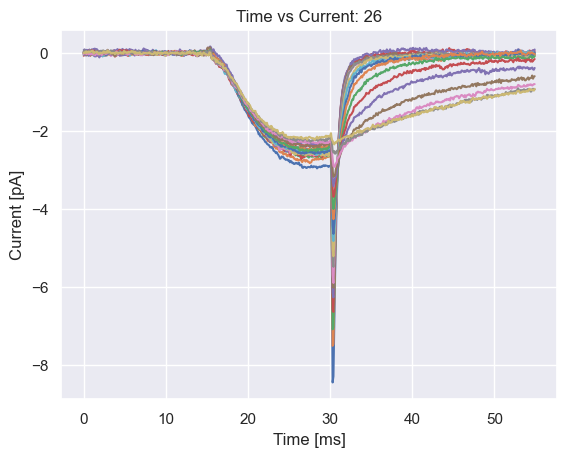

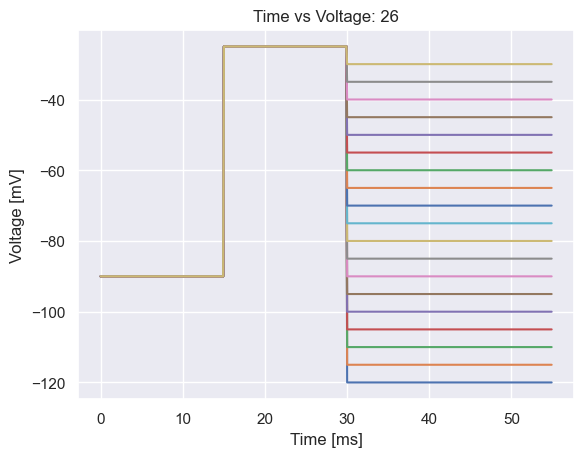

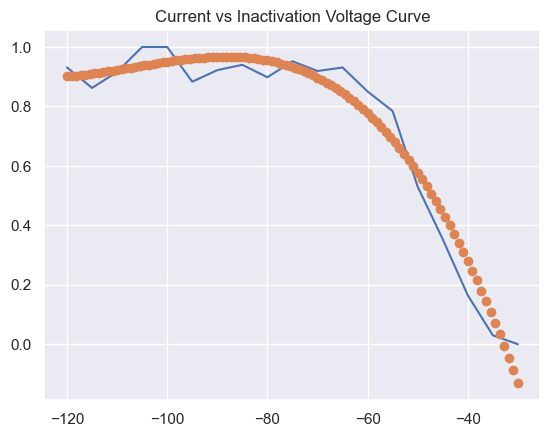

([-119.99999731779099,
  -114.99999463558197,
  -109.99999940395355,
  -104.99999672174454,
  -99.99999403953552,
  -94.9999988079071,
  -89.99999612569809,
  -85.00000089406967,
  -79.99999821186066,
  -74.99999552965164,
  -70.00000029802322,
  -64.99999761581421,
  -59.99999865889549,
  -54.999999701976776,
  -49.99999701976776,
  -44.999998062849045,
  -39.99999910593033,
  -35.00000014901161,
  -29.999999329447746],
 array([0.93113772, 0.86227545, 0.91616766, 1.        , 1.        ,
        0.88323353, 0.92215569, 0.94011976, 0.89820359, 0.95209581,
        0.91916168, 0.93113772, 0.8502994 , 0.78443114, 0.52994012,
        0.35329341, 0.16467066, 0.02994012, 0.        ]),
 array([-119.99999732, -119.09090643, -118.18181554, -117.27272465,
        -116.36363376, -115.45454287, -114.54545199, -113.6363611 ,
        -112.72727021, -111.81817932, -110.90908843, -109.99999754,
        -109.09090665, -108.18181576, -107.27272487, -106.36363399,
        -105.4545431 , -104.54545221, -10

In [34]:
voltage_activation_analysis(some, 26)

## Bringing it all together
Now, let's try running these functions on multiple different cells (differentiated by cell ID) and see if we can find any sort of significance/assess reproducibility in terms of activation/inactivation curves based exclusively on voltage. First, let's collect the data and store it in various dictionaries.

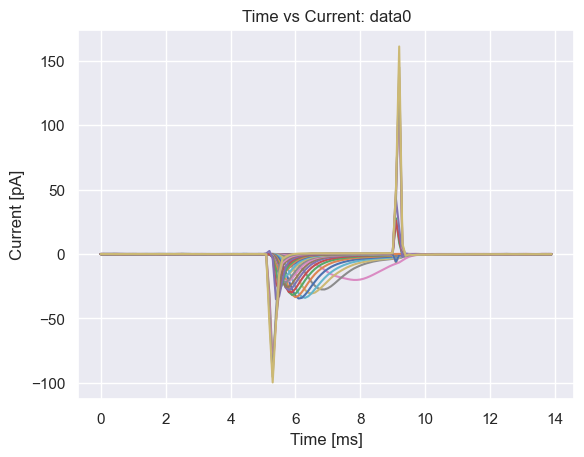

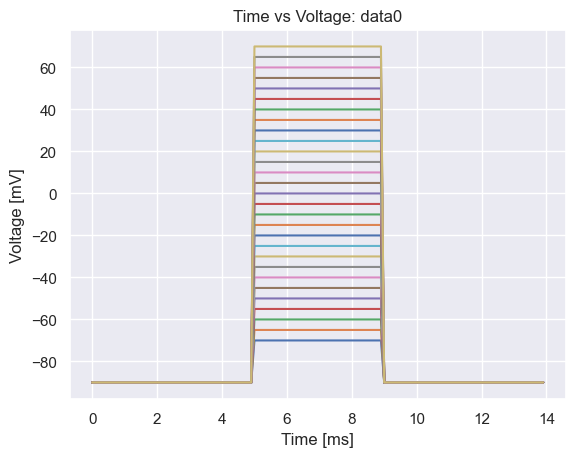

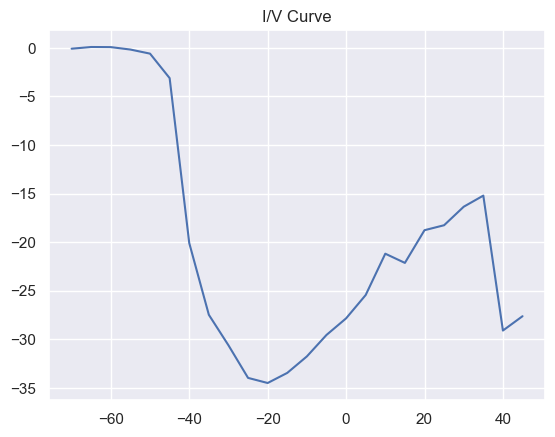

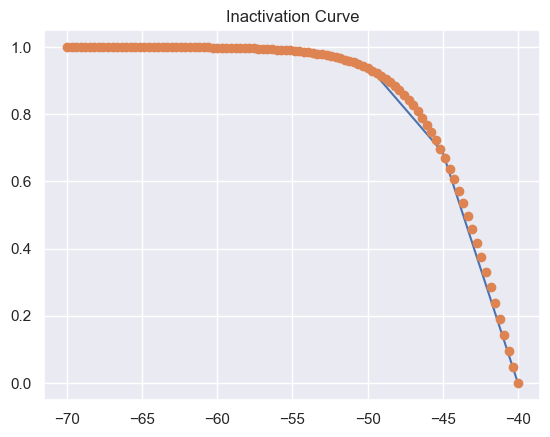

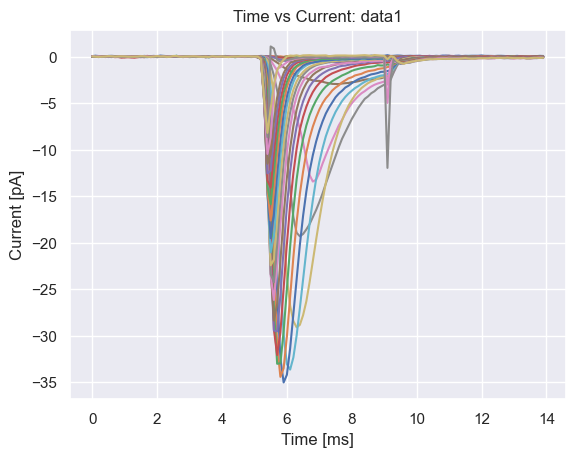

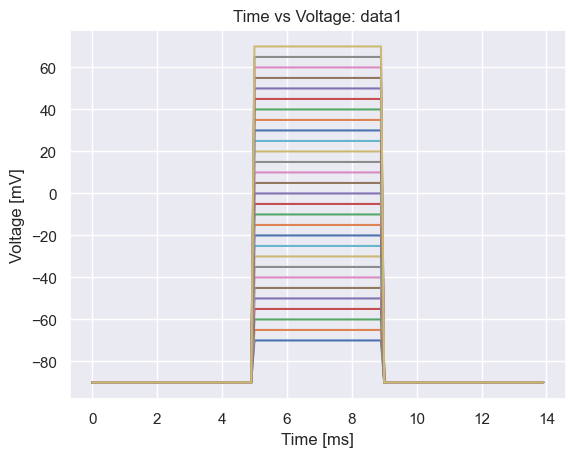

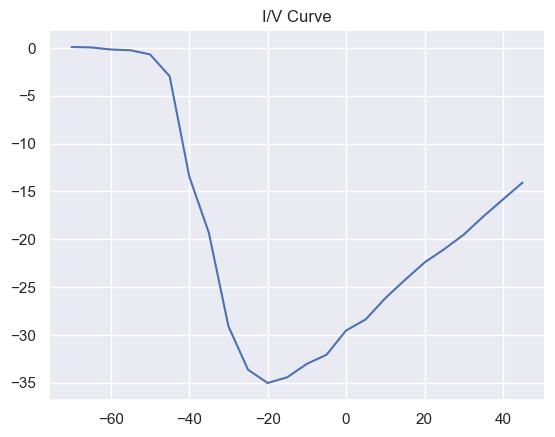

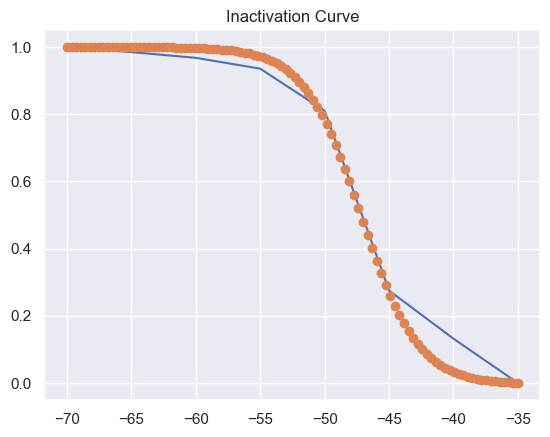

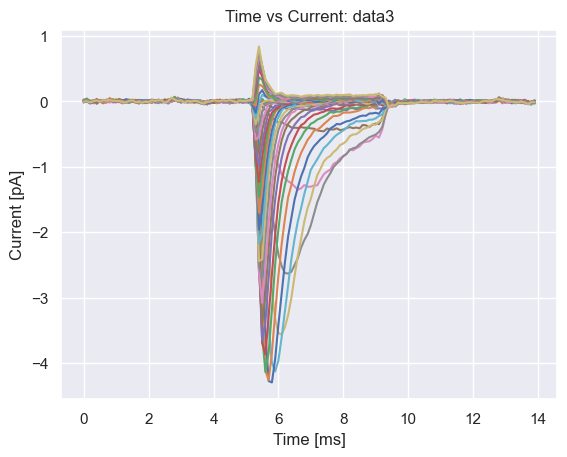

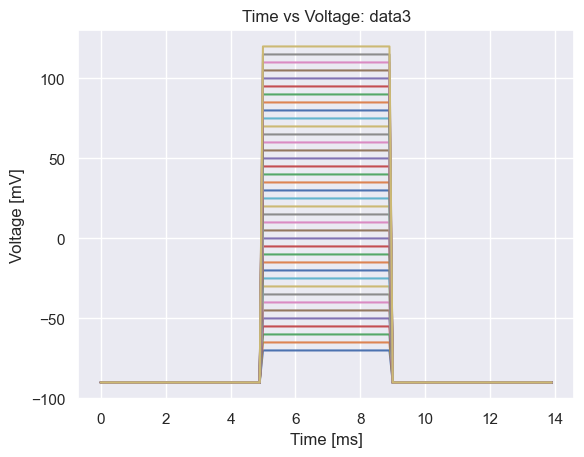

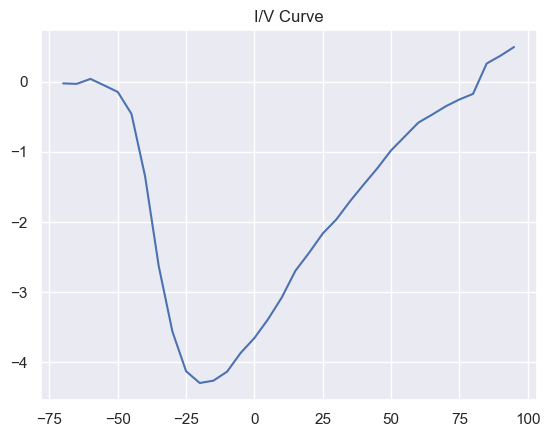

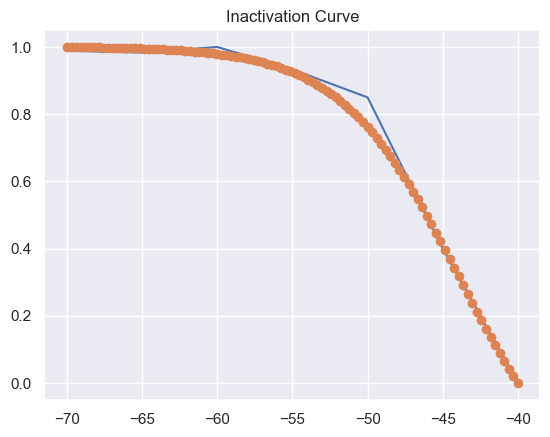

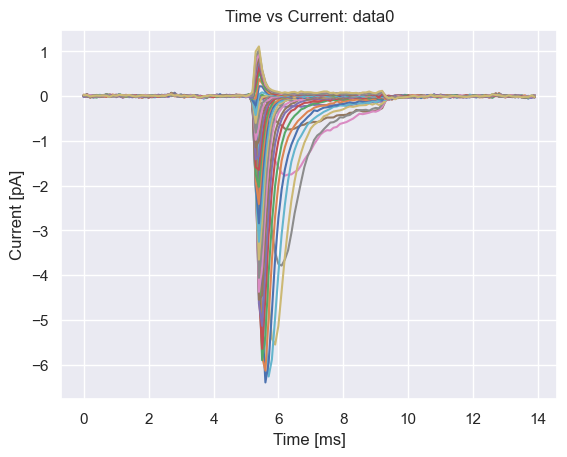

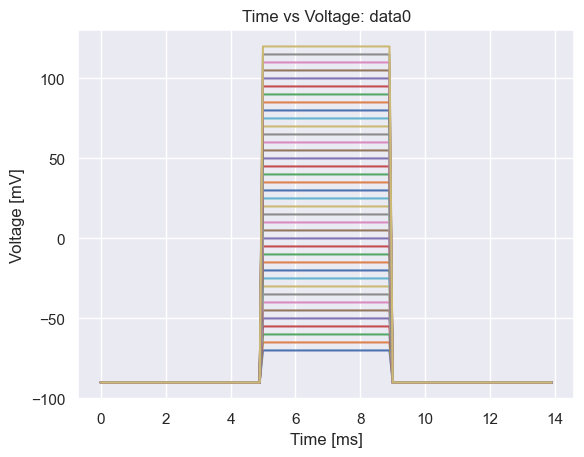

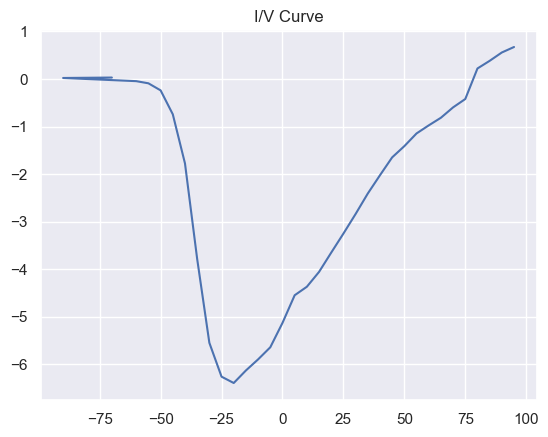

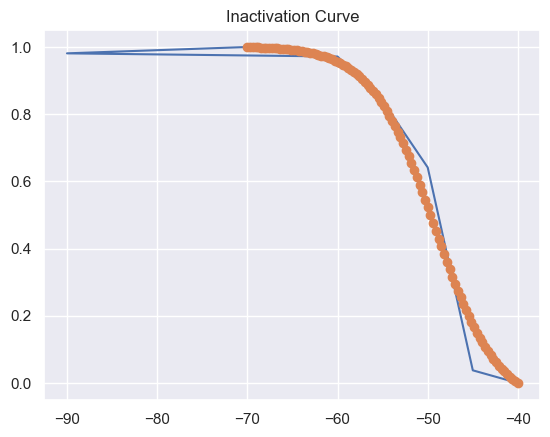

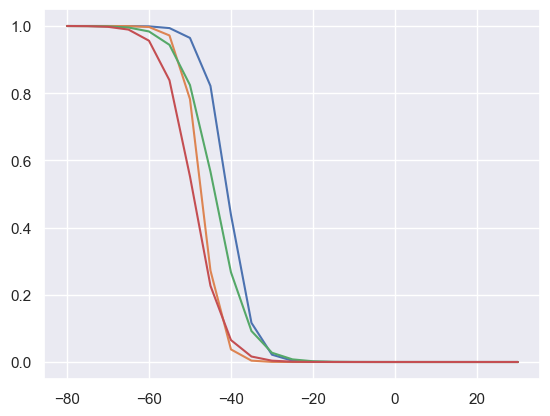

In [37]:
indices = [['239', 'data0'], ['240', 'data1'], ['290', 'data3'], ['292', 'data0']]

tracking_inactivation = {}
current_voltage = {}
voltages = np.arange(-80, 35, 5)
inactivation = {key: [] for key in voltages}
for x in indices:
    index = x[0]
    dataset = x[1]
    voltage_step, max_current, V_range, I_over_Imax_fit, activation_tail_current, Imax_fit, V1_2_fit, k_fit = inactivation_analysis(final[index], dataset)
    tracking_inactivation[index] = [Imax_fit, V1_2_fit, k_fit]
    if np.min(max_current) < -10:
        max_current = np.array(max_current)/8
    current_voltage[index] = [voltage_step, max_current]
for y, items in tracking_inactivation.items():
    V_range = np.arange(-80, 35, 5)
    yvals = boltzmann(V_range, items[0], items[1], items[2])
    yvals = (yvals - np.min(yvals)) / (np.max(yvals) - np.min(yvals))
    for i, key in enumerate(inactivation.keys()):
        inactivation[key].append(yvals[i])
    plt.plot(V_range, yvals)
plt.show()

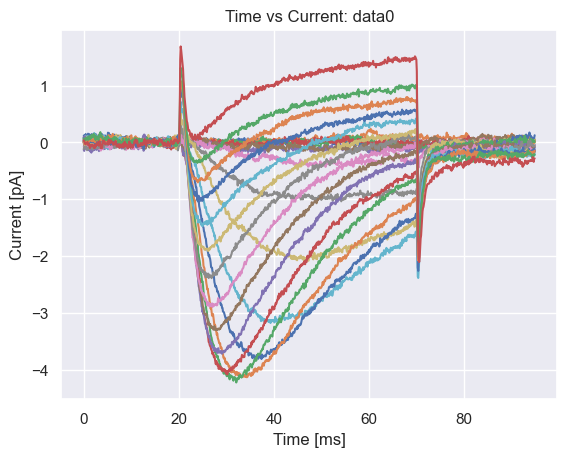

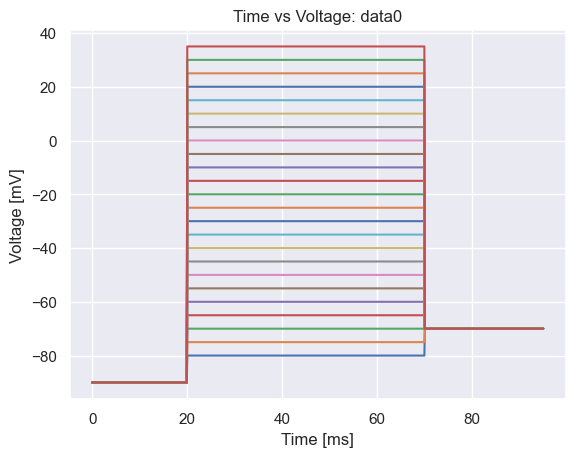

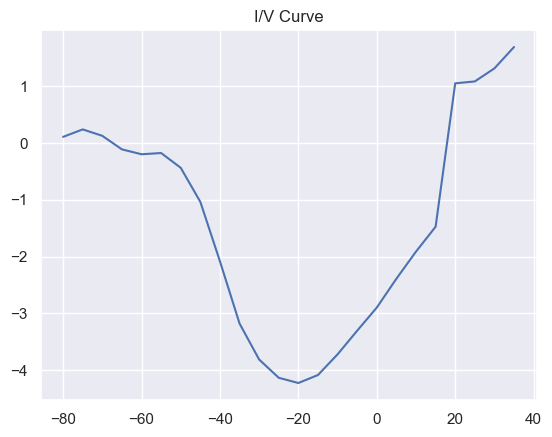

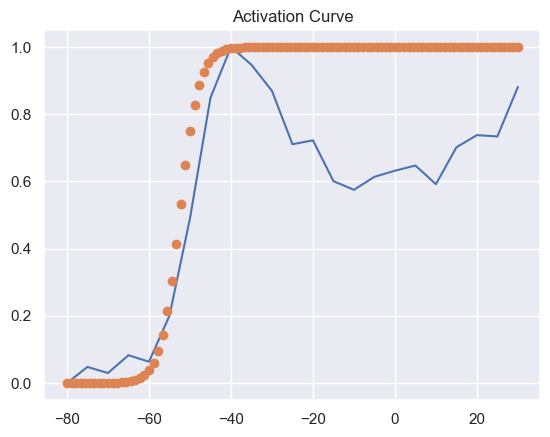

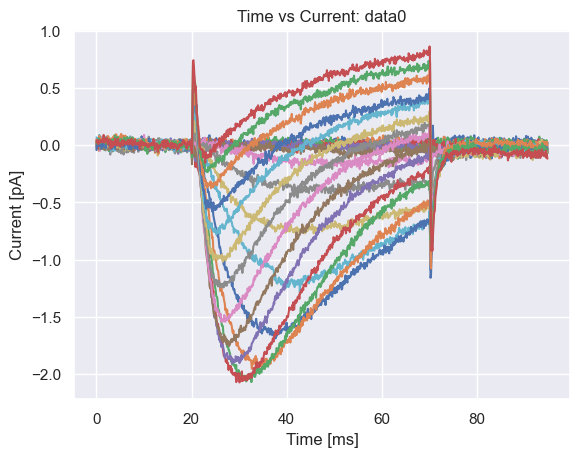

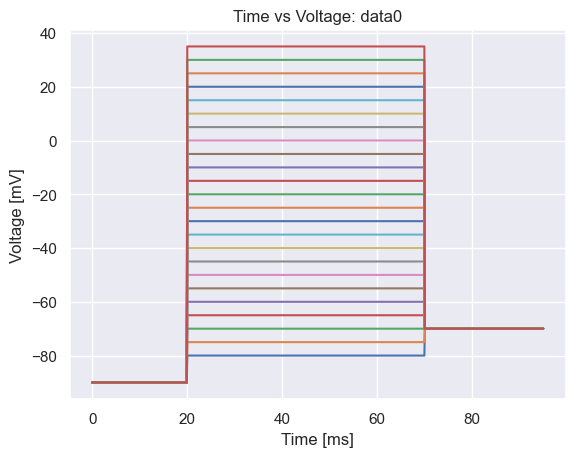

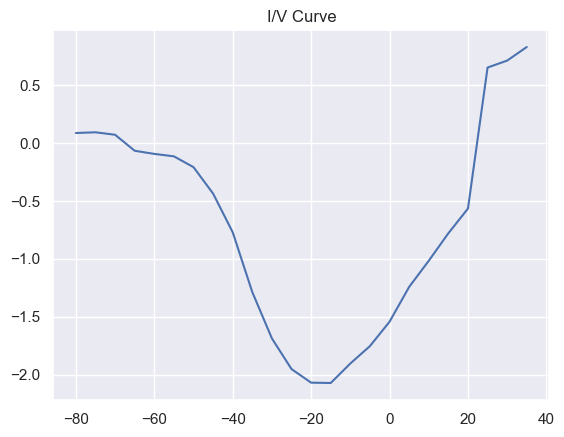

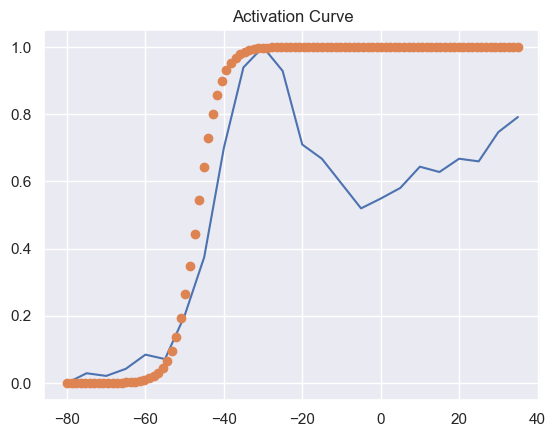

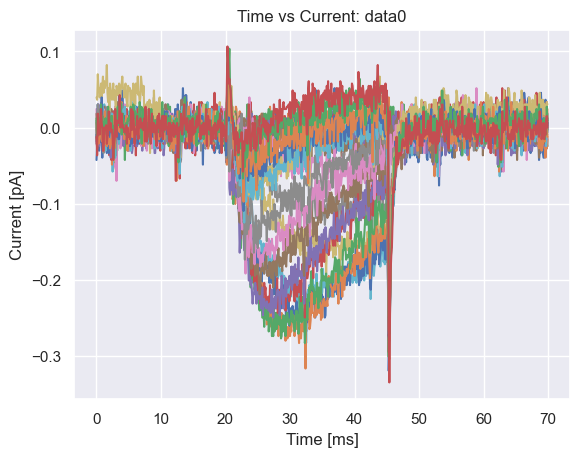

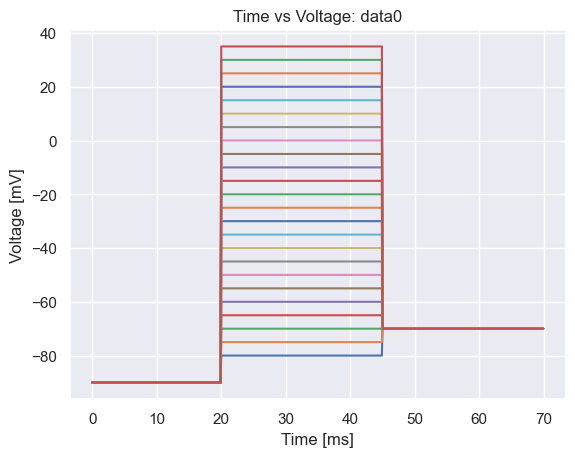

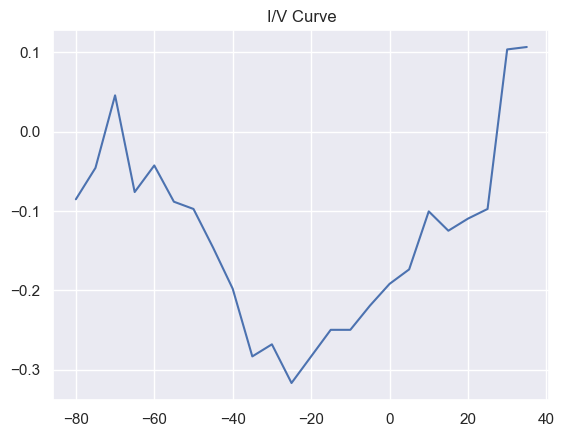

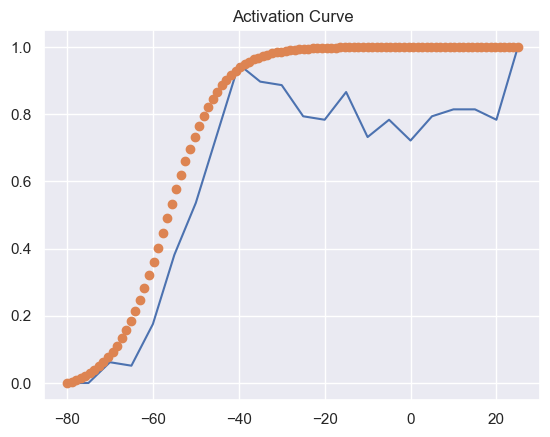

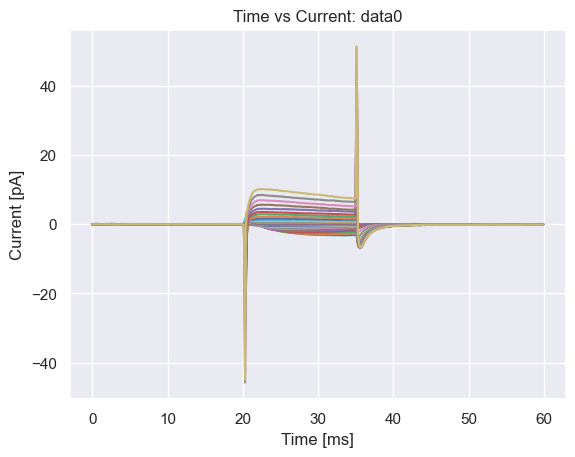

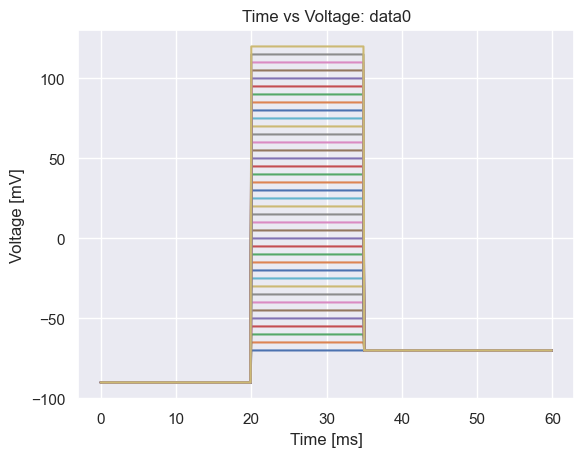

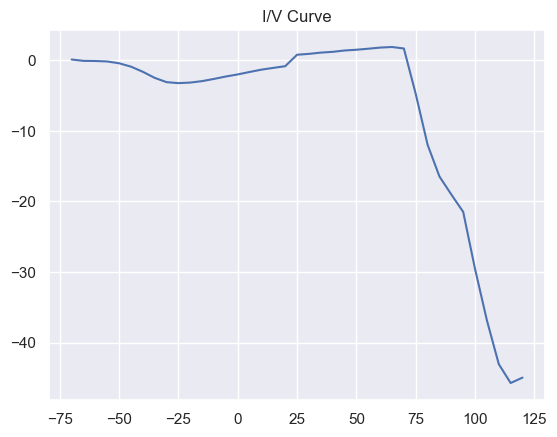

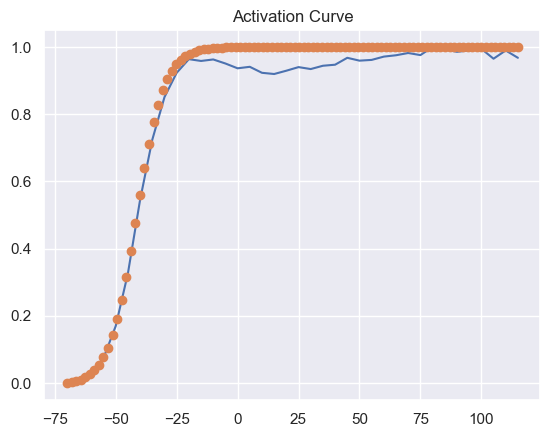

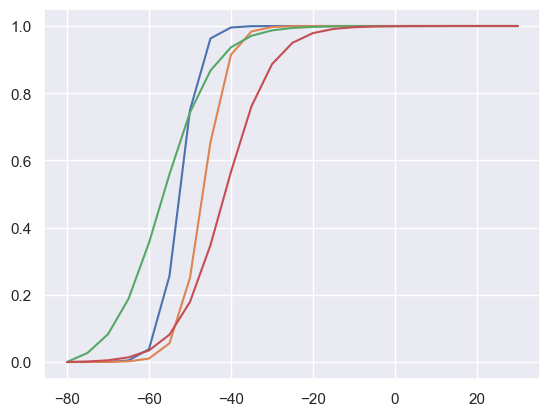

In [38]:
indices = ['288', '287', '277', '212']

tracking_activation = {}
voltages = np.arange(-80, 35, 5)
activation = {key: [] for key in voltages}

for x in indices:
    voltage_step, max_current, V_range, I_over_Imax_fit, activation_tail_current, Imax_fit, V1_2_fit, k_fit = activation_analysis(final[x], 'data0')
    tracking_activation[x] = [Imax_fit, V1_2_fit, k_fit]
    current_voltage[x] = [voltage_step, max_current]
for y, items in tracking_activation.items():
    V_range = np.arange(-80, 35, 5)
    yvals = boltzmann(V_range, items[0], items[1], items[2])
    yvals = 1-((yvals - np.min(yvals)) / (np.max(yvals) - np.min(yvals)))
    for i, key in enumerate(activation.keys()):
        activation[key].append(yvals[i])
    plt.plot(V_range, yvals)
plt.show()

Now, let's aggregate that data and compare the inactivation/activation curves across samples and compute an "average" curve for both activation and inactivation.

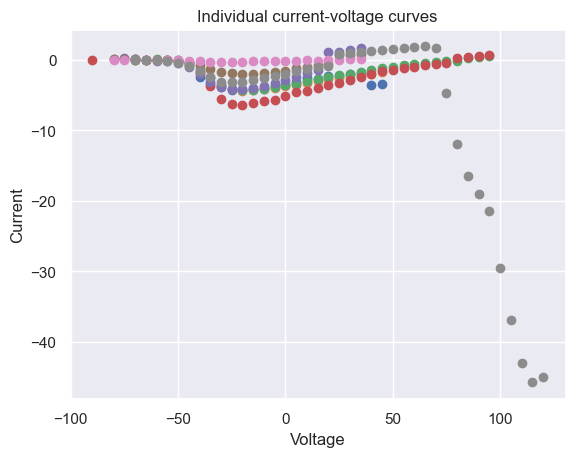

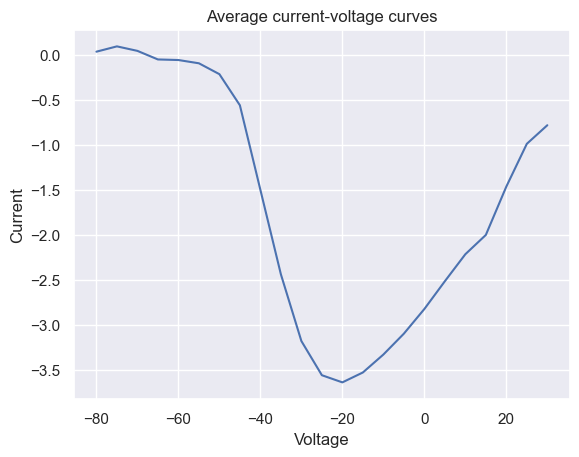

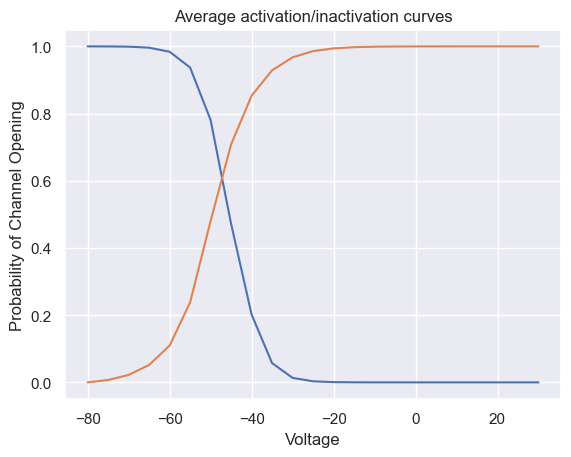

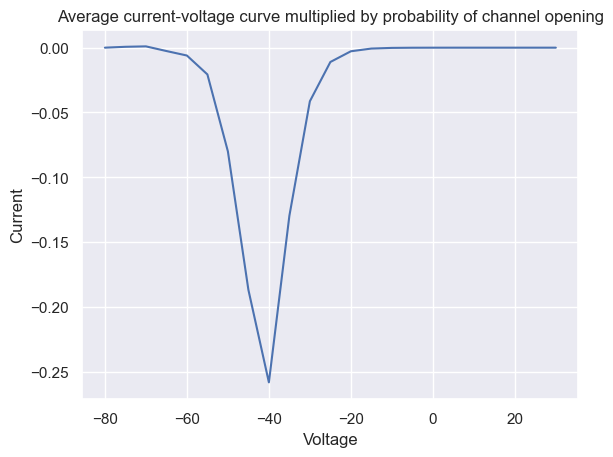

In [44]:
for y, items in current_voltage.items():
    plt.plot(items[0], items[1], 'o')
plt.title('Individual current-voltage curves')
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.show()

tolerance = 0.1

voltages = np.arange(-80, 35, 5)
agg_current_voltage = {}
avg_current_voltage = {}
avg_activation = []
avg_inactivation = []
for voltage in voltages:
    current_values = []
    activation_values = []
    inactivation_values = []
    for index, (voltage_list, current_list) in current_voltage.items():
        for i, v in enumerate(voltage_list):
            if abs(v-voltage) < tolerance:
                current_values.append(current_list[i])
    agg_current_voltage[voltage] = current_values
    avg_current_voltage[voltage] = np.mean(current_values)
    avg_activation.append(np.mean(activation[voltage]))
    avg_inactivation.append(np.mean(inactivation[voltage]))
v = []
i = []
for voltage, current in avg_current_voltage.items():
    v.append(voltage)
    i.append(current)

combo = np.array(avg_inactivation)*np.array(avg_activation)
final = np.array(i)*np.array(combo)

plt.plot(v, i)
plt.title('Average current-voltage curves')
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.show()
plt.plot(v, avg_inactivation, label = 'inactivation')
plt.plot(v, avg_activation, label = 'activation')
plt.title('Average activation/inactivation curves')
plt.xlabel('Voltage')
plt.ylabel('Probability of Channel Opening')

plt.show()
plt.plot(v, final)
plt.title('Average current-voltage curve multiplied by probability of channel opening')
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.show()